In [261]:
import sys
import os
import uproot
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import awkward as ak
import random
import math

In [4]:
# pd.set_option('display.max_columns', None)

## Set Up and Load the DataFrame

In [5]:
# List of variables to include in the DataFrame

# variables = ['selected', 'evt', 'sub', 'run', 'nslice', 'shr_energy_tot_cali','_opfilter_pe_beam',
#              '_opfilter_pe_veto','slice_orig_pass_id','n_tracks_contained', 'truthFiducial', 'npi0', 'elec_e',
#             'CosmicIPAll3D', 'hits_ratio', 'shrmoliereavg', 'subcluster', 'trkfit', 'tksh_distance', #'shr_tkfit_nhits_tot',
#             'shr_tkfit_dedx_max', 'n_showers_contained', 'shr_tkfit_nhits_Y', 'shr_tkfit_nhits_U', 'shr_tkfit_nhits_V']

# Other useful variables that I want to plot
variables = ['evt', 'run', 'sub','slice_orig_pass_id', 'truthFiducial', 'npi0', 'elec_e', 
             'shr_tkfit_nhits_Y', 'shr_tkfit_nhits_U', 'shr_tkfit_nhits_V',
             'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_U', 'shr_tkfit_dedx_V',
             'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z',
            ]

# These variables are calculated from the initial loading of the DataFrame, so should be included in the total list until later
added_vars = ['shr_tkfit_nhits_tot', 'trksemlbl', 'trkpid', 'slcng2_total', 'clung2_total']

# Separate out the variables used for the loose cuts for clarity
new_loose_cut_variables = [
    'nslice',
    'selected',
    'shr_energy_tot_cali', # total energy in the shower
    '_opfilter_pe_beam',
    '_opfilter_pe_veto',
    'n_tracks_contained', # number of tracks
    'CosmicIPAll3D',
    'trksemlbl', # how track like the shower is
    'hits_ratio',
    'shrmoliereavg', # shower molier angle
    'subcluster',
    'trkfit',
    'tksh_distance',
    'shr_tkfit_nhits_tot', # number of hits in the shower (combined between all planes)
    'shr_tkfit_dedx_max', # energy deposition rate at beginning of the shower
    'n_showers_contained'
]

# (MIP/HIP/shower/Michel/diffuse)
nugraph_variables = [
    'slcng2mip', 'slcng2hip', 'slcng2shr', 'slcng2mcl', 'slcng2dfs', 'slcng2bkg', # nu graph slice hit counts for each semantic label and for background
    'clung2mip', 'clung2hip', 'clung2shr', 'clung2mcl', 'clung2dfs', 'clung2bkg', # nu graph hit count of hits in PFPs (i.e. clustered) for each semantic label and for background
    'nhits_r1cm', 'nhits_r3cm', 'nhits_r5cm', 'nhits_r10cm', # total number of hits within 1/3/5/10 cm of neutrino vertex
    'ng2hip_r1cm', 'ng2hip_r3cm', 'ng2hip_r5cm', 'ng2hip_r10cm', # number of HIP-labeled hits within 1/3/5/10 cm of neutrino vertex
    'ng2clu_hip_r1cm', 'ng2clu_hip_r3cm', 'ng2clu_hip_r5cm', 'ng2clu_hip_r10cm', # number of HIP-labeled hits within 1/3/5/10 cm of neutrino vertex that are clustered in PFPs
    'ng2clu_hippfp_r1cm', 'ng2clu_hippfp_r3cm', 'ng2clu_hippfp_r5cm', 'ng2clu_hippfp_r10cm', # number of HIP-labeled hits within 1/3/5/10 cm of neutrino vertex that are clustered in a HIP-labeled PFPs 
#     'pfng2hip_r1cm', 'pfng2hip_r3cm', 'pfng2hip_r5cm', 'pfng2hip_r10cm' # number of HIP-labeled hits within 1/3/5/10 cm of neutrino vertex in each PFP (commenting since a vector)
]

# Combine the variables into a array for loading the DataFrame
variables.extend(new_loose_cut_variables)
variables.extend(nugraph_variables)
variables = list(set([var for var in variables if var not in added_vars]))
# variables = list(np.unique(np.array(variables)))
variables

['subcluster',
 'slcng2shr',
 'slcng2mcl',
 'ng2clu_hip_r5cm',
 'ng2clu_hippfp_r5cm',
 'slcng2mip',
 'shr_tkfit_dedx_max',
 'trkfit',
 'ng2hip_r3cm',
 '_opfilter_pe_beam',
 'nhits_r5cm',
 '_opfilter_pe_veto',
 'ng2clu_hip_r10cm',
 'slcng2hip',
 'ng2clu_hip_r3cm',
 'tksh_distance',
 'ng2clu_hippfp_r3cm',
 'slice_orig_pass_id',
 'shr_tkfit_nhits_V',
 'evt',
 'shr_energy_tot_cali',
 'hits_ratio',
 'elec_e',
 'true_nu_vtx_y',
 'n_showers_contained',
 'slcng2bkg',
 'clung2mip',
 'CosmicIPAll3D',
 'nhits_r10cm',
 'ng2clu_hippfp_r1cm',
 'run',
 'clung2bkg',
 'ng2hip_r1cm',
 'ng2hip_r5cm',
 'clung2dfs',
 'shr_tkfit_nhits_U',
 'nhits_r3cm',
 'truthFiducial',
 'sub',
 'clung2shr',
 'true_nu_vtx_x',
 'slcng2dfs',
 'ng2hip_r10cm',
 'shr_tkfit_nhits_Y',
 'nhits_r1cm',
 'clung2mcl',
 'shr_tkfit_dedx_Y',
 'shr_tkfit_dedx_V',
 'ng2clu_hippfp_r10cm',
 'selected',
 'n_tracks_contained',
 'shrmoliereavg',
 'clung2hip',
 'npi0',
 'ng2clu_hip_r1cm',
 'true_nu_vtx_z',
 'shr_tkfit_dedx_U',
 'nslice']

In [6]:
# Load one file for easier viewing
t = uproot.open('DetVar/v01/prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run1_reco2_reco2.root')['nuselection']['NeutrinoSelectionFilter']
df = t.arrays(variables, library="pd")
df.sort_values(by=['run','evt'])
# df = df.drop_duplicates()

# print(df.index)

# df['ident_id'] = df['run'] * 1000000 + df['sub']*10000 + df['evt']
# #     df = df.droplevel('subentry')
# df = df.set_index('ident_id')
# df = df.drop_duplicates()

# print(df.index)
# print(df.index.is_unique)
# print(df.loc[:,['run', 'sub', 'evt']])
# print(df)

,subcluster,slcng2shr,slcng2mcl,ng2clu_hip_r5cm,ng2clu_hippfp_r5cm,slcng2mip,shr_tkfit_dedx_max,trkfit,ng2hip_r3cm,_opfilter_pe_beam,...,ng2clu_hippfp_r10cm,selected,n_tracks_contained,shrmoliereavg,clung2hip,npi0,ng2clu_hip_r1cm,true_nu_vtx_z,shr_tkfit_dedx_U,nslice
26905,2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-3.402823e+38,1.000000,-2147483648,539.701416,...,-2147483648,0,0,-3.402408e+38,-2147483648,0,-2147483648,1013.026917,-3.402823e+38,0
26906,8,240,1,0,0,12,1.834861e+00,0.110619,0,220.426590,...,0,1,0,3.851074e+00,0,0,0,267.721008,1.091939e+00,1
26907,2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-3.402823e+38,1.000000,-2147483648,4599.764160,...,-2147483648,0,0,-3.402408e+38,-2147483648,0,-2147483648,133.164703,-3.402823e+38,0
26908,19,1340,2,0,0,0,2.030725e+00,0.347054,0,627.195557,...,0,1,0,6.402344e+00,14,0,0,948.192322,2.023217e+00,1
14233,3,82,0,7,0,0,2.964928e+00,0.660714,4,0.000000,...,0,0,0,1.757422e+01,8,0,4,38.568516,-3.402823e+38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,12,312,17,9,9,288,1.869079e+00,0.218837,37,231.553955,...,9,1,1,4.986328e+00,31,0,8,500.101288,3.741783e-01,1
80163,2147483648,994,1,8,0,13,-3.402823e+38,1.000000,41,1915.221924,...,0,0,0,-3.402408e+38,8,1,3,733.479126,-3.402823e+38,1
80164,2147483648,256,26,55,13,52,-3.402823e+38,1.000000,46,317.089661,...,13,0,3,-3.402408e+38,64,0,14,488.059326,-3.402823e+38,1
80165,19,961,31,33,33,4,5.868633e+00,0.068404,37,894.755249,...,33,1,2,4.642578e+00,73,1,12,609.226135,1.747556e+00,1


In [7]:
t.keys()

['selected',
 'run',
 'sub',
 'evt',
 'trk_id',
 'shr_id',
 'trk2_id',
 'shr2_id',
 'trk3_id',
 'shr3_id',
 'shr_energy_tot',
 'shr_energy',
 'shr_energy_second',
 'shr_energy_third',
 'shr_energy_tot_cali',
 'shr_energy_cali',
 'shr_energy_second_cali',
 'shr_energy_third_cali',
 'shr_theta',
 'shr_phi',
 'shr_pca_0',
 'shr_pca_1',
 'shr_pca_2',
 'shr_px',
 'shr_py',
 'shr_pz',
 'shr_openangle',
 'shr_tkfit_start_x',
 'shr_tkfit_start_y',
 'shr_tkfit_start_z',
 'shr_tkfit_theta',
 'shr_tkfit_phi',
 'shr_start_x',
 'shr_start_y',
 'shr_start_z',
 'shr_dedx_Y',
 'shr_dedx_V',
 'shr_dedx_U',
 'shr_dedx_Y_cali',
 'shr_dedx_V_cali',
 'shr_dedx_U_cali',
 'shr_tkfit_dedx_Y',
 'shr_tkfit_dedx_V',
 'shr_tkfit_dedx_U',
 'shr_tkfit_dedx_max',
 'shr_tkfit_nhits_Y',
 'shr_tkfit_nhits_V',
 'shr_tkfit_nhits_U',
 'shr_llrpid_dedx_Y',
 'shr_llrpid_dedx_V',
 'shr_llrpid_dedx_U',
 'shr_llrpid_dedx',
 'shr_tkfit_dedx_Y_alt',
 'shr_tkfit_dedx_V_alt',
 'shr_tkfit_dedx_U_alt',
 'shr_tkfit_nhits_Y_alt',
 'sh

In [8]:
# Set the files to grab nue data
# CV should be set as the last file in the lists

directory = 'DetVar/v01/'

file_names = [
#               'prodgenie_bnb_intrinsic_nue_overlay_detvar_sce_reco2_run1_reco2_reco2.root',
              'prodgenie_bnb_intrinsic_nue_overlay_DetVar_wiremod_ScaledEdX_v08_00_00_42_run1_reco2_reco2.root',
              'prodgenie_bnb_intrinsic_nue_overlay_DetVar_wiremod_ScaleX_v08_00_00_42_run1_reco2_reco2.root',
              'prodgenie_bnb_intrinsic_nue_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_42_run1_reco2_reco2.root',
              'prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleXZ_v08_00_00_42_run1_reco2_reco2.root',
#               'prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleYZ_v08_00_00_42_run1_reco2_reco2.root'
#               'dontuse_____prodgenie_bnb_intrinsic_nue_overlay_DetVar_wiremod_ScaleX_v08_00_00_42_run1_reco2_reco2.root'
              'prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run1_reco2_reco2.root'
             ]

variation_titles = [ 
#                     'sce', 
                    'wiremod_ScaledEdX', 
                    'wiremod_ScaleX', 
                    'wiremod_ScaleYZ', 
                    'WireModAngleXZ', 
#                     'WireModAngleYZ'
#                     'wiremod_ScaleX (10%)'
                    'CV'
                   ]

plot_labels = [ 
#                     'sce', 
                    'Scale dEdX', 
                    'Scale X', 
                    'Scale YZ', 
                    'Angle XZ', 
#                     'Angle YZ'
#                     'Scale X (10%)'
                    'Central Value'
                   ]

mode = 'Nue'

In [9]:
# Set the files to grab pi0 data (cuts are different so dont use)

# directory = 'DetVar/v00/'

# file_names = ['prodgenie_nc_pi0_overlay_DetVar_CV_reco2_v08_00_00_38_run3a_reco2_reco2.root',
# #               'prodgenie_nc_pi0_overlay_DetVar_SCE_reco2_v08_00_00_38_run3a_reco2_reco2.root',
#               'prodgenie_nc_pi0_overlay_DetVar_wiremod_ScaledEdX_v08_00_00_39_run3a_reco2_reco2.root',
#               'prodgenie_nc_pi0_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3a_reco2_reco2.root',
# #               'prodgenie_nc_pi0_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3a_reco2_reco2.root',
#               'prodgenie_nc_pi0_overlay_DetVar_WireModAngleXZ_v08_00_00_38_run3a_reco2_reco2.root',
#               'prodgenie_nc_pi0_overlay_DetVar_WireModAngleYZ_v08_00_00_38_run3a_reco2_reco2.root'
#              ]

# variation_titles = ['CV', 
# #                     'sce', 
#                     'wiremod_ScaledEdX', 
#                     'wiremod_ScaleX', 
# #                     'wiremod_ScaleYZ', 
#                     'WireModAngleXZ', 
#                     'WireModAngleYZ'
#                    ]

# plot_labels = [ 
# #                     'sce', 
#                     'Scale dEdX', 
#                     'Scale X', 
# #                     'Scale YZ', 
#                     'Angle XZ', 
#                     'Angle YZ',
# #                     'Scale X (10%)'
#                     'Central Value'
#                    ]

# mode='Pi0'

In [10]:
# Utility functions

def get_elm_from_vec_idx(myvec, idx, fillval=np.nan):
    """Returns the element of a vector at position idx, where idx is a vector of indices. If idx is out of bounds, returns a filler value"""
    return np.array([pidv[tid] if ((tid < len(pidv)) & (tid >= 0)) else fillval for pidv, tid in zip(myvec, idx)])

def get_idx_from_vec_sort(argidx, vecsort, mask):
    """Returns the index of the element of a vector at position argidx, where argidx is a vector of indices. If argidx is out of bounds, returns -1."""
    vid = vecsort[mask]
    sizecheck = argidx if argidx >= 0 else abs(argidx) - 1
    # find the position in the array after masking
    mskd_pos = [ak.argsort(v)[argidx] if len(v) > sizecheck else -1 for v in vid]
    # go back to the corresponding position in the origin array before masking
    result = [[i for i, n in enumerate(m) if n == 1][p] if (p) >= 0 else -1 for m, p in zip(mask, mskd_pos)]
    return result

In [11]:
# Get all of the DataFrames into a list
# (This is time consuming so try and only do this once)

df_list = [] # A list that contains the dataframes for each variation separately (df_list[-1] should be CV)

for file in file_names:
    
    # Loading the DataFrame with all variables required for further analysis and plotting
    file_name = f'{directory}{file}'
    t = uproot.open(file_name)['nuselection']['NeutrinoSelectionFilter']
    df = t.arrays(variables, library="pd")
    df = df.drop_duplicates()
    
    # Add unique event identifier as an index to the DataFrame
    df['ident_id'] = df['run'] * 1000000 + df['sub']*10000 + df['evt']
    df = df.set_index('ident_id')
    
    # Ensure that every event has a unique index (assuming by other logic)
    if not df.index.is_unique:
        raise Exception(f'Index not unique for file: {file}')
    
    # Add trksemblbl and trkpid to the DataFrame
    trk_id_o = t.arrays(["trk_id"], library="np")["trk_id"] - 1 #2k sample
    pfng2semlabel = t.arrays(["pfng2semlabel"])["pfng2semlabel"]
    trk_pfng2semlabel_sel = get_elm_from_vec_idx(pfng2semlabel, trk_id_o)
    df["trksemlbl"] = trk_pfng2semlabel_sel

    trk_llr_pid_v = t.arrays(["trk_llr_pid_score_v"])["trk_llr_pid_score_v"]
    trk_id = t.arrays(["trk_id"], library="np")["trk_id"] - 1
    trk_llr_pid_v_sel = get_elm_from_vec_idx(trk_llr_pid_v, trk_id)
    df["trkpid"] = trk_llr_pid_v_sel
    
    # Add shr_tkfit_nhits_tot to the DataFrame
    df['shr_tkfit_nhits_tot'] = df['shr_tkfit_nhits_Y'] + df['shr_tkfit_nhits_U'] + df['shr_tkfit_nhits_V']
    
    # Sum the total number of nugraph2 hits in each category
    df['slcng2_total'] = df['slcng2mip'] + df['slcng2hip'] + df['slcng2shr'] + df['slcng2mcl'] + df['slcng2dfs'] + df['slcng2bkg']
    df['clung2_total'] = df['clung2mip'] + df['clung2hip'] + df['clung2shr'] + df['clung2mcl'] + df['clung2dfs'] + df['clung2bkg']
    
    # Fix unsigned columns so that differences are two-sided
    # And turn boolean values into integers to allow for subtraction
    uint_cols = np.unique(df.select_dtypes(include=['uint32', 'bool']).columns.to_numpy())
    df[uint_cols] = df[uint_cols].astype('int32')

    df_list.append(df)

## Filter Events and Create Indexes

In [12]:
# Get the shared events and perform cuts

cv_index = df_list[-1].index # Assume CV is the last in the list

share_rate = [] # Array to display information about filtering

# Indexes used for picking out shared events between variations
shared_index = [] # Contains an index that picks out events shared between each variation and CV that pass the chosen filter (for CV it is all cv events)
shared_index_all = cv_index # A single index that contains the intersection between all of the indexes that pass the chosen filter
intersected_index_all = cv_index # A single index contains the intersection between all of the indexes (before any filters)

# Indexes at different filtering stages used for calculating the cut efficiency and plotting histograms
before_index = [] # ALL events for each variation that pass this filter
before_shared_index = [] # Only events that pass this filter in EACH variation and CV
before_shared_index_all = cv_index # Only events that pass this filter in ALL variations and CV
before_intersected_index = [] # Only events shared by ALL variations and CV that pass this filter for EACH variation 

pre_index = []
pre_shared_index = []
pre_shared_index_all = cv_index
pre_intersected_index = []

cut_index = []
cut_shared_index = []
cut_shared_index_all = cv_index
cut_intersected_index = []

for i in range(len(df_list)):
    
    # Section
    intersected_index_all = intersected_index_all.intersection(df_list[i].index)
    
    # Filter out specific events of interest
    df_before = df_list[i]
    df_before = df_before[df_before['truthFiducial'] == True] 
    df_before = df_before[df_before['npi0'] == 0]
    cv_before = df_list[-1]
    cv_before = cv_before[cv_before['truthFiducial'] == True]
    cv_before = cv_before[cv_before['npi0'] == 0]
    
    before_index.append(df_before.index)
    before_shared_index.append(df_before.index.intersection(cv_before.index))
    before_shared_index_all = before_shared_index_all.intersection(df_before.index)
    
    # Perform Preselection
    df_pre = df_before
    df_pre = df_pre[df_pre['nslice'] == 1] 
    df_pre = df_pre[df_pre['selected'] == 1]
    df_pre = df_pre[df_pre['shr_energy_tot_cali'] > 0.07]
    df_pre = df_pre[(df_pre['_opfilter_pe_beam'] > 0) & (df_pre['_opfilter_pe_veto'] < 20)]
    cv_pre = cv_before
    cv_pre = cv_pre[cv_pre['nslice'] == 1] 
    cv_pre = cv_pre[cv_pre['selected'] == 1] 
    cv_pre = cv_pre[cv_pre['shr_energy_tot_cali'] > 0.07] 
    cv_pre = cv_pre[(cv_pre['_opfilter_pe_beam'] > 0) & (cv_pre['_opfilter_pe_veto'] < 20)] 
    
    pre_index.append(df_pre.index)
    pre_shared_index.append(df_pre.index.intersection(cv_pre.index))
    pre_shared_index_all = pre_shared_index_all.intersection(df_pre.index)
    
    # Perform cuts
    df_cut = df_pre
    df_cut = df_cut[df_cut['n_tracks_contained'] > 0] # cut to separate Np and 0p
    df_cut = df_cut[df_cut['CosmicIPAll3D'] > 10]
    df_cut = df_cut[df_cut['trksemlbl'] == 1]
    df_cut = df_cut[df_cut['hits_ratio'] > 0.40]
    df_cut = df_cut[df_cut['shrmoliereavg'] < 22]
    df_cut = df_cut[df_cut['subcluster'] > 4]
    df_cut = df_cut[df_cut['trkfit'] < 0.5]
    df_cut = df_cut[df_cut['tksh_distance'] < 4.0]
    df_cut = df_cut[df_cut['shr_tkfit_nhits_tot'] > 1]
    df_cut = df_cut[df_cut['shr_tkfit_dedx_max'] > 1]
    df_cut = df_cut[df_cut['shr_tkfit_dedx_max'] < 3]
    df_cut = df_cut[df_cut['n_showers_contained'] == 1]
    cv_cut = cv_pre
    cv_cut = cv_cut[cv_cut['n_tracks_contained'] > 0] # cut to separate Np and 0p
    cv_cut = cv_cut[cv_cut['CosmicIPAll3D'] > 10]
    cv_cut = cv_cut[cv_cut['trksemlbl'] == 1]
    cv_cut = cv_cut[cv_cut['hits_ratio'] > 0.40]
    cv_cut = cv_cut[cv_cut['shrmoliereavg'] < 22]
    cv_cut = cv_cut[cv_cut['subcluster'] > 4]
    cv_cut = cv_cut[cv_cut['trkfit'] < 0.5]
    cv_cut = cv_cut[cv_cut['tksh_distance'] < 4.0]
    cv_cut = cv_cut[cv_cut['shr_tkfit_nhits_tot'] > 1]
    cv_cut = cv_cut[cv_cut['shr_tkfit_dedx_max'] > 1]
    cv_cut = cv_cut[cv_cut['shr_tkfit_dedx_max'] < 3]
    cv_cut = cv_cut[cv_cut['n_showers_contained'] == 1]
    
    cut_index.append(df_cut.index)
    cut_shared_index.append(df_cut.index.intersection(cv_cut.index))
    cut_shared_index_all = cut_shared_index_all.intersection(df_cut.index)
    
    # Calculate the percentage of events shared after pre-selection
    num_total_events = len(before_index[i])
    num_shared_events = len(pre_shared_index[i])
    share_rate.append(num_shared_events / num_total_events)

# Use a second loop to populate the portions of the shared set that pass each filter
for i in range(len(df_list)):
    before_intersected_index.append(before_index[i].intersection(intersected_index_all))
    pre_intersected_index.append(pre_index[i].intersection(intersected_index_all))
    cut_intersected_index.append(cut_index[i].intersection(intersected_index_all))    
    
print(f'Before any filtering: {[len(df.index) for df in df_list]}')
print(f'After basic filtering: {[len(index) for index in before_index]}')
print(f'After pre-selection: {[len(index) for index in pre_index]}')
print(f'After cuts: {[len(index) for index in cut_index]}')
print(f'After pre-selection, the ratio of shared events between DetVar and CV is:\n{share_rate}')

# Pick the default choice for shared_index (this can be overrided by using the specific array instead)
shared_index = pre_shared_index # Contains an index that picks out events shared between each variation and CV (for CV it is all cv events)
shared_index_all = pre_shared_index_all # A single index that contains the union between all of the indexes

print(f'Based on choice of filtering, {len(shared_index_all)} events are shared between all variations')


Before any filtering: [82746, 82619, 82615, 83416, 88471]
After basic filtering: [36800, 36792, 36771, 37078, 39338]
After pre-selection: [27534, 27520, 27605, 27782, 29457]
After cuts: [7518, 7651, 7580, 7672, 8147]
After pre-selection, the ratio of shared events between DetVar and CV is:
[0.6740760869565218, 0.6722113502935421, 0.6747436838813196, 0.682884729489185, 0.7488179368549495]
Based on choice of filtering, 16698 events are shared between all variations


## Utility Functions

In [13]:
# Takes the indices of the desired variations and calculated the relative error of the first from the second
#  var gives the variable to calculate the relative errors for
#  index gives the list of events to look at (defaults to the set defined earlier)
def get_rel_errors(var, index=shared_index):
    rel_errors = []
    for i in range(len(df_list)-1):
        detvar = df_list[i].loc[index[i]][var]
        cv = df_list[-1].loc[index[i]][var]

        relative_error = ( detvar - cv ) / cv

        rel_errors.append(relative_error)
            
    return rel_errors

In [14]:
# Takes an array and returns the relative freqeuncies of items being in the supplied bins
#  The total counts that each bin is divided by is the total number (not just the events that are in the range of the bins)
def get_rel_frequencies(a, bins):
    
    total = len(a)

    hist = np.histogram(np.array(a),bins)[0]
    hist = hist/total # Convert to relative frequency

    return hist

## Set Up Variable to Plot

In [152]:
var_bounds = {
    'hits_ratio': { # name of the variable
        'bins': np.linspace(0, 1, 20), # bin edges for the variables values
        'err_bins': np.linspace(-0.1, 0.1, 24), # bin edges for the relative error in this variable between DetVar and CV
        'limits': [0.40], # values that are used in the cuts
        'limit_tag' : '>', # type of cut (>, =, ...) (only '=' or not '=' matters)
        'special' : [] # variables that should be excluded because they indicate a NaN value (9999, int.max, ...)
    },
    'shr_energy_tot_cali': {
        'bins': np.linspace(0, 2, 30),
        'err_bins': np.linspace(-0.075, 0.075, 24),
        'limits': [0.07],
        'limit_tag' : '>',
        'special' : [9999]
    },
    'shrmoliereavg': {
        'bins': np.linspace(0, 50, 20),
        'err_bins': np.linspace(-1, 1.5, 20),
        'limits': [22],
        'limit_tag' : '<',
        'special' : []
    },
    'shr_tkfit_dedx_max': {
        'bins': np.linspace(0, 20, 20),
        'err_bins': np.linspace(-0.1, 0.1, 24),
        'limits': [1, 3],
        'limit_tag' : '>',
        'special' : [np.finfo(np.float32).min]
    },
    'shr_tkfit_dedx_Y': {
        'bins': np.linspace(0, 10, 20),
        'err_bins': np.linspace(-0.1, 0.1, 24),
        'limits': [1, 3],
        'limit_tag' : '>',
        'special' : []
    },
    'shr_tkfit_dedx_U': {
        'bins': np.linspace(0, 10, 20),
        'err_bins': np.linspace(-0.1, 0.1, 24),
        'limits': [1, 3],
        'limit_tag' : '>',
        'special' : []
    },
    'shr_tkfit_dedx_V': {
        'bins': np.linspace(0, 10, 20),
        'err_bins': np.linspace(-0.1, 0.1, 24),
        'limits': [1, 3],
        'limit_tag' : '>',
        'special' : []
    },
    'n_tracks_contained': {
        'bins': np.linspace(-0.5, 7.5, 9),
        'err_bins': np.linspace(-1, 1.5, 10),
        'limits': [1],
        'limit_tag' : '>',
        'special' : []
    },
    'subcluster': {
        'bins': np.linspace(-0.5, 50.5, 52),
        'err_bins': np.linspace(-1.25, 1.25, 20),
        'limits': [4],
        'limit_tag' : '>',
        'special' : []
    },
    'trkfit': {
        'bins': np.linspace(0, 1, 20),
        'err_bins': np.linspace(-1, 2, 20),
        'limits': [0.5],
        'limit_tag' : '<',
        'special' : []
    },
    'CosmicIPAll3D': {
        'bins': np.linspace(0, 10000, 20),
        'err_bins': np.linspace(-10000, 10000, 20),
        'limits': [0.5],
        'limit_tag' : '>',
        'special' : []
    },
    'n_showers_contained': {
        'bins': np.linspace(-0.5, 8.5, 10),
        'err_bins': np.linspace(-1.25, 1.25, 10),
        'limits': [1],
        'limit_tag' : '==',
        'special' : []
    },
    'tksh_distance': { # Has values at integer limit
        'bins': np.linspace(0, 15, 20),
        'err_bins': np.linspace(-1, 2, 20),
        'limits': [4],
        'limit_tag' : '<',
        'special' : []
    },
    'trksemlbl': {
        'bins': np.linspace(-0.5, 4.5, 6),
        'err_bins': np.linspace(-0.5, 4.5, 6),
        'limits': [1],
        'limit_tag' : '=',
        'special' : []
    },
    '_opfilter_pe_beam': {
        'bins': np.linspace(0, 300, 30),
        'err_bins': np.linspace(-0.25, 0.25, 20),
        'limits': [0],
        'limit_tag' : '>',
        'special' : []
    },
    '_opfilter_pe_veto': {
        'bins': np.linspace(0, 100, 30),
        'err_bins': np.linspace(-1, 1, 20),
        'limits': [20],
        'limit_tag' : '<',
        'special' : []
    },
    'shr_tkfit_nhits_tot': {
        'bins': np.linspace(-0.5, 30.5, 32),
        'err_bins': np.linspace(-1, 2, 20),
        'limits': [20],
        'limit_tag' : '<',
        'special' : []
    },
    'slcng2shr': {
        'bins': np.linspace(0,100,20),
        'err_bins': np.linspace(-0.2, 0.2, 20),
        'limits': [],
        'limit_tag' : '',
        'special' : []
    },
    'ng2hip_r3cm': {
        'bins': np.linspace(0,200,20),
        'err_bins': np.linspace(-0.2, 0.2, 20),
        'limits': [],
        'limit_tag' : '',
        'special' : []
    },
    'ng2hip_r1cm': {
        'bins': np.linspace(0,50,20),
        'err_bins': np.linspace(-0.2, 0.2, 20),
        'limits': [],
        'limit_tag' : '',
        'special' : []
    },
    'ng2clu_hippfp_r3cm': {
        'bins': np.linspace(0,75,20),
        'err_bins': np.linspace(-0.2, 0.2, 20),
        'limits': [],
        'limit_tag' : '',
        'special' : []
    },
    'ng2clu_hippfp_r1cm': {
        'bins': np.linspace(0,30,20),
        'err_bins': np.linspace(-0.2, 0.2, 20),
        'limits': [],
        'limit_tag' : '',
        'special' : []
    }
}

for nugraph_var in nugraph_variables:
    if nugraph_var not in var_bounds.keys():
        var_bounds[nugraph_var] = {'bins': np.linspace(0,1000,20),
                                    'err_bins': np.linspace(-0.2, 0.2, 20),
                                    'limits': [], 'limit_tag' : '', 'special' : [] }

var = 'shr_tkfit_dedx_max' # Variable 1 used for primary histograms
var2 = 'ng2clu_hippfp_r1cm' # Variable 2 used for secondary histograms (like sectioning based on first variable)

def getBounds(var): # Wrapper function to define the necessary quanities for plotting histograms for each variable
    
    if var in var_bounds.keys(): # Get the specified values if available
        
        bins = var_bounds[var]['bins']
        err_bins = var_bounds[var]['err_bins']
        limits = var_bounds[var]['limits']
        limit_tag = var_bounds[var]['limit_tag']
        special = var_bounds[var]['special']
        
    else: # Otherwise, automatically determine the bounds for the histograms to be refined by manually adding the variable later
        
        # Determine the min and max values that would appear for each variable
        diff_values = [[error.min(), error.max()] for error in get_rel_errors(var)]
        df_values = [[df[var].min(), df[var].max()] for df in df_list]

        # Take the absolute min and max across all variations to generate binning
        if df_list[-1][var].dtype in ['uint32','int32']: # Different behavior for integer values so bins line up with possibilities
            bin_min = np.round(np.min(df_values))-0.5
            bin_max = np.round(np.max(df_values))+0.5
            bins = np.linspace(bin_min, bin_max, int(bin_max - bin_min + 1))

            err_bin_min = np.round(np.min(diff_values))-0.5
            err_bin_max = np.round(np.max(diff_values))+0.5
            err_bins = np.linspace(err_bin_min, err_bin_max, int(err_bin_max - err_bin_min + 1))
        else:
            bins = np.linspace(np.min(df_values), np.max(df_values),20)
            err_bins = np.linspace(np.min(diff_values), np.max(df_values),20)

        # Default to empty limits and special values
        limits = []
        limit_tag = ''
        special = []
        
        # Print out what would need to be added to var_bounds
        print(f"""{var}:{{
    'bins': np.linspace({min(bins)}, {max(bins)}, {len(bins)}), 
    'err_bins': np.linspace({min(err_bins)}, {max(err_bins)}, {len(err_bins)}), 
    'limits': [], 
    'limit_tag': '', 
    'special': []
}}""")
    
    # Calculate the bin centers and widths for convenience later
    bin_centers = (bins[:-1]+bins[1:])/2
    bin_width = bins[1]-bins[0]

    err_bin_centers = (err_bins[:-1]+err_bins[1:])/2
    err_bin_width = err_bins[1]-err_bins[0]
        
    return bins, err_bins, limits, limit_tag, special, bin_centers, bin_width, err_bin_centers, err_bin_width

bins, err_bins, limits, limit_tag, special, bin_centers, bin_width, err_bin_centers, err_bin_width = getBounds(var)
bins2, err_bins2, limits2, limit_tag2, special2, bin_centers2, bin_width2, err_bin_centers2, err_bin_width2 = getBounds(var2)

# Make sure inf values are excluded always
default_special = [np.finfo(np.float32).min, np.finfo(np.float32).max, np.iinfo(np.int32).min, np.iinfo(np.int32).max, 3.4024083e+38, -3.4024083e+38]


special.extend(default_special)
special2.extend(default_special)


## Remove special values from shared_index

In [153]:
# Filter out the special values that shouldn't count in averages or other quantities like covariance
#  index and index_all are indexes like shared_index (list of indexes) and shared_index_all (single index)
#  var_list is a list of variable names
#  special can be specified as a list of values to filter if a variable isn't in var_bounds
#  na says whether to remove NaN values as well as anything in special (can't put nan in special since it never equates to True)

def filter_index(index, index_all, var_list, special = default_special, na=True, exponent_threshold=10, variation_index=None):

    filtered_shared_index = index[:]
    filtered_shared_index_all = index_all
    
    for var_temp in var_list:
        
        # Determine the values to filter
        if var_temp in var_bounds.keys():
            special_temp = var_bounds[var_temp]['special']    
        elif special.len(special) == len(var_list):
            special_temp = special[var_list.index(var_temp)]
        elif special:       
            special_temp = special  
        else:
            special_temp = []

        for i in range(len(df_list)-1):
            
            if variation_index and i != variation_index:
                continue

            cv_share = df_list[-1].loc[index[i]]
            detvar_share = df_list[i].loc[index[i]]

            filtered_shared_index[i] = filtered_shared_index[i].intersection(cv_share[~cv_share[var_temp].isin(special_temp)].index)
            filtered_shared_index[i] = filtered_shared_index[i].intersection(detvar_share[~detvar_share[var_temp].isin(special_temp)].index)  

            if na:
                
                filtered_shared_index[i] = cv_share.loc[filtered_shared_index[i]].dropna(subset=[var_temp]).index
                filtered_shared_index[i] = detvar_share.loc[filtered_shared_index[i]].dropna(subset=[var_temp]).index
                
            filtered_shared_index[i] = filtered_shared_index[i].intersection(cv_share[cv_share[var_temp] < 10**exponent_threshold].index)
            filtered_shared_index[i] = filtered_shared_index[i].intersection(cv_share[cv_share[var_temp] > -10**exponent_threshold].index)
            filtered_shared_index[i] = filtered_shared_index[i].intersection(detvar_share[detvar_share[var_temp] < 10**exponent_threshold].index) 
            filtered_shared_index[i] = filtered_shared_index[i].intersection(detvar_share[detvar_share[var_temp] > -10**exponent_threshold].index)  
            
            filtered_shared_index_all = index_all.intersection(filtered_shared_index[i])
        
    return filtered_shared_index[:], filtered_shared_index_all

In [154]:
filtered_shared_index, filtered_shared_index_all = filter_index(shared_index, shared_index_all, [var, var2], special = [special, special2])
# print(df_list[1].loc[filtered_shared_index[1]])

## Section Off Outliers in the First Variable

In [155]:
sectioned_index = [] # Contains the events in EACH variation that are considered outliers

section_label = '<>' # Which direction from the diagonal to section off (>, <, <>, =)
section_value = 0.3 # What percentage of the max bin range do outliers need to be from the diagonal

for i in range(len(df_list)-1):

    detvar = df_list[i].loc[shared_index[i]][var]
    cv = df_list[-1].loc[shared_index[i]][var]

#     error = ( detvar - cv ) / cv
    error = (detvar - cv)/np.max(bins)

    if section_label == '>':
        new_index = df_list[i].loc[shared_index[i]][error > section_value].index
    elif section_label == '<':
        new_index = df_list[i].loc[shared_index[i]][error < section_value].index
    elif section_label == '<>':
        new_index = df_list[i].loc[shared_index[i]][error < -1*section_value].index
        new_index = new_index.union(df_list[i].loc[shared_index[i]][error > section_value].index)
    elif section_label == '=':
        new_index = df_list[i].loc[shared_index[i]][error == section_value].index
    else:
        new_index = shared_index[i] # Should cause no change

    sectioned_index.append(shared_index[i].intersection(new_index))

## Plot 1D Histograms for the First Variable

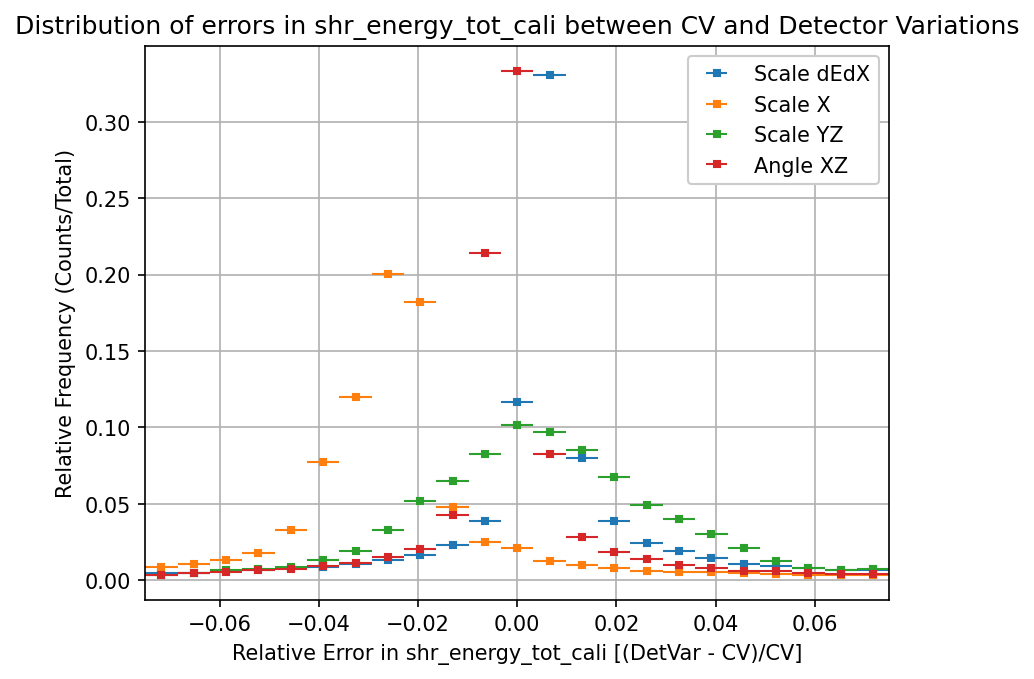

In [19]:
# Relative errors

rel_errors = get_rel_errors(var)

fig, ax = plt.subplots(dpi=150)
    
for i in range(len(df_list)-1):
    
    hist = get_rel_frequencies(rel_errors[i], err_bins)
    
    ax.errorbar(err_bin_centers,hist,xerr=err_bin_width/2,ls='none',marker='s',ms=2.5,lw=1,label=plot_labels[i])
#     err_ax.stairs(hist, err_bins, label=labels[i])
    
ax.grid(True)
ax.legend(framealpha=1)
ax.set_xlim(min(err_bins), max(err_bins))
ax.set_title(f'Distribution of errors in {var} between CV and Detector Variations')
ax.set_ylabel('Relative Frequency (Counts/Total)')
ax.set_xlabel(f'Relative Error in {var} [(DetVar - CV)/CV]');

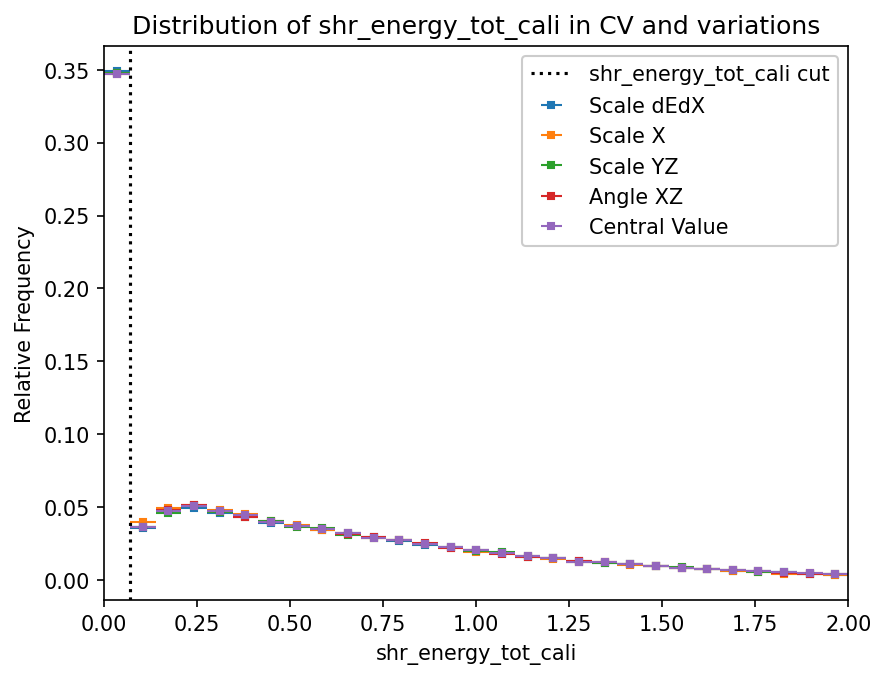

In [20]:
# Distribution of variable 1

fig, ax = plt.subplots(dpi=150)

for i in range(len(df_list)):
    
    hist = get_rel_frequencies(np.array(df_list[i][var]), bins)

    ax.errorbar(bin_centers,hist,xerr=bin_width/2,ls='none',marker='s',ms=2.5,lw=1, label=plot_labels[i]) #, edgecolor='black')

for i in range(len(limits)): 
    limit = limits[i]
    if i == 0 : # Only add one label for multiple limits
        ax.axvline(limit, ls=':',c='k', label=f'{var} cut')
    else:
        ax.axvline(limit, ls=':',c='k')
    
ax.legend(framealpha=1)
ax.set_xlim(min(bins), max(bins))
ax.set_title(f'Distribution of {var} in CV and variations')
ax.set_ylabel('Relative Frequency')
ax.set_xlabel(f'{var}');

## Plot 2D Histograms

In [21]:
def plot_2d_hist_grid(var, bins, index, xlabel, ylabel, title, axis_titles=plot_labels, dpi=100, limits=None, plot_diagonal=True):
    
    # Allow passing a single index by duplicating it for each variation
    if len(index) == 1:
        index = [idx for _ in df_list[:-1]]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, dpi=dpi)
    axs = axs.flatten()

    # Get the maximum bin value to set as the vmax
    vmax = 10
    for i in range(len(df_list)-1):
        vmax = max(vmax, np.max(np.histogram2d(df_list[-1].loc[index[i]][var], df_list[i].loc[index[i]][var], bins=bins)[0]))
        
    for i in range(len(df_list)-1):
        
        if len(index[i]) == 0:
            continue
        
        print(len(index[i]))

        _,_,_,im = axs[i].hist2d(df_list[-1].loc[index[i]][var], df_list[i].loc[index[i]][var], 
                                 bins=bins, norm=mpl.colors.LogNorm(vmax=vmax))

        axs[i].set_title(f'{axis_titles[i]}')

        for limit in limits: 
            axs[i].axvline(limit, ls='--',c='k', linewidth=0.8)
            axs[i].axhline(limit, ls='--',c='k', linewidth=0.8)

        # Add diagonal line
        if plot_diagonal:
            axs[i].plot([min(bins),max(bins)], [min(bins),max(bins)], linestyle='-', c='k', linewidth=0.9, alpha=0.8)

    fig.supylabel(xlabel)
    fig.supxlabel(ylabel)
    fig.suptitle(title)

    fig.colorbar(im, ax=axs.ravel().tolist());

24806
24732
24811
25320


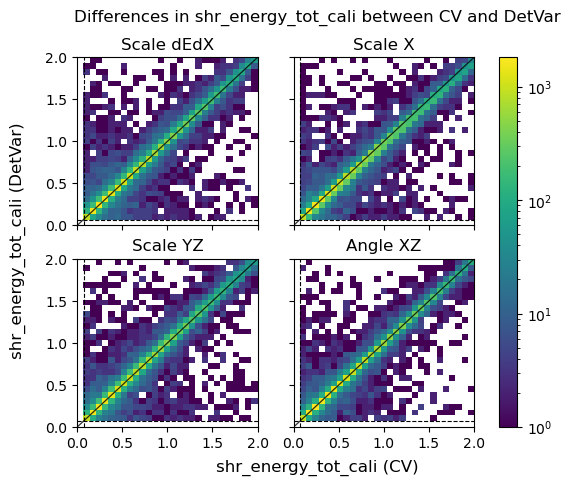

In [22]:
# All variable 1 (shared) events 
plot_2d_hist_grid(var, 
                  bins, 
                  shared_index, 
                  f'{var} (DetVar)', 
                  f'{var} (CV)', 
                  f'Differences in {var} between CV and DetVar', 
                  limits=limits)

583
364
556
303


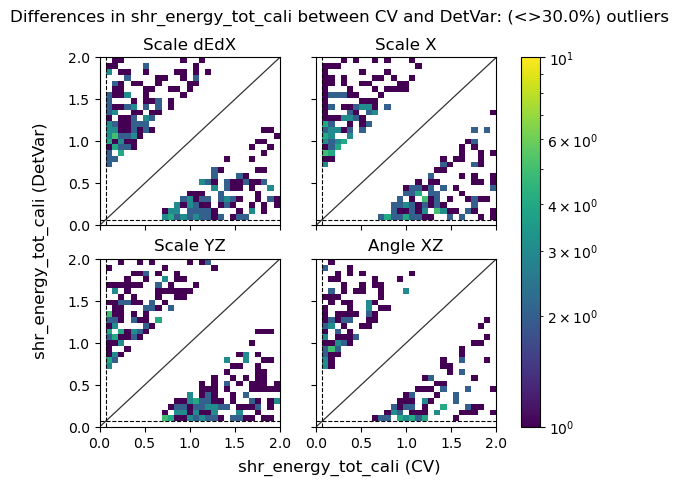

In [23]:
# Variable 1 outlier events
plot_2d_hist_grid(var, 
                  bins, 
                  sectioned_index, 
                  f'{var} (DetVar)', 
                  f'{var} (CV)', 
                  f'Differences in {var} between CV and DetVar: ({section_label}{section_value*100}%) outliers', 
                  limits=limits)

24806
24732
24811
25320


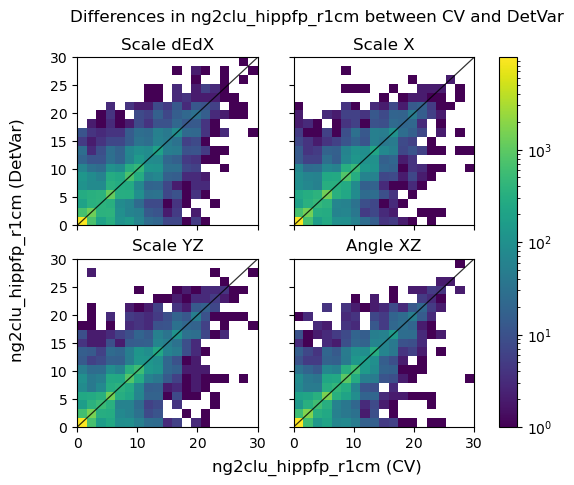

In [24]:
# All variable 2 (shared) events
plot_2d_hist_grid(var2, 
                  bins2, 
                  shared_index, 
                  f'{var2} (DetVar)', 
                  f'{var2} (CV)', 
                  f'Differences in {var2} between CV and DetVar', 
                  limits=limits2)

583
364
556
303


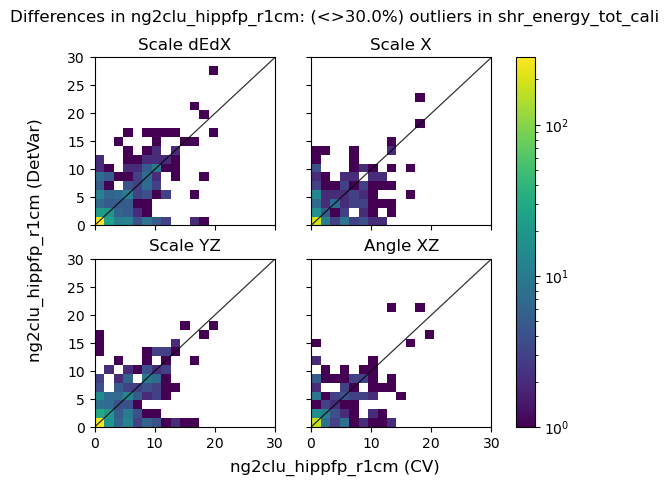

In [25]:
# Variable 1 outlier events plotted for variable 2
plot_2d_hist_grid(var2, 
                  bins2, 
                  sectioned_index, 
                  f'{var2} (DetVar)', 
                  f'{var2} (CV)', 
                  f'Differences in {var2}: ({section_label}{section_value*100}%) outliers in {var}', 
#                   f'Differences in {var2} between CV and DetVar events: ({section_label}{section_value*100}%) outliers in {var}', 
                  limits=limits2)

## Correlation Matrix For a Single Variable

In [26]:
matrix_bins = np.linspace(0,10,15)
matrix_bin_centers = (matrix_bins[:-1]+matrix_bins[1:])/2
matrix_bin_width = matrix_bins[1]-matrix_bins[0]

In [27]:
# function copied from Dr. Caratelli
def get_covariance(n_cv,n_var):
    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n_var[i] - n_cv[i])*(n_var[j] - n_cv[j])

    frac_cov = np.empty([len(n_cv), len(n_cv)])
    corr = np.empty([len(n_cv), len(n_cv)])

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            frac_cov[i][j] =  cov[i][j] / (n_cv[i] * n_cv[j])
            corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])
    return cov,frac_cov,corr

In [28]:
num_bins = len(matrix_bins) - 1
num_variations = len(df_list)-1

cv_hist = np.histogram(df_list[-1].loc[shared_index_all, [var]].to_numpy(), matrix_bins)[0]

matrix = np.zeros((num_bins, num_bins))

for i in range(num_variations):

    hist = np.histogram(df_list[i].loc[shared_index_all, [var]].to_numpy(), matrix_bins)[0]
    
    cov, frac_cov, corr = get_covariance(cv_hist, hist)
    
    matrix += corr
    
#     diffs = (hist - cv_hist)/sum(hist + cv_hist)
#     diffs = (hist - cv_hist)/sum(cv_hist)
#     diffs = (hist - cv_hist)
# #     diffs = (hist - np.mean(hist))/hist
# #     diffs = (hist - cv_hist)/hist
    
#     print(diffs)
    
#     for j in range(num_bins):
        
#         for k in range(num_bins):
            
# #             print(f'{j},{k}: {diffs[j]*diffs[k]}')
        
# #             matrix[j][k] += diffs[j]*diffs[k]
#             sign_j = math.copysign(1, diffs[j])
#             sign_k = math.copysign(1, diffs[k])
# #             matrix[j][k] += sign_j*sign_k
        
# #             matrix[j][k] += diffs[j]*diffs[k]
# #             matrix[j][k] += diffs[j]*diffs[k]/num_bins/num_bins
# #             matrix[j][k] += diffs[j]*diffs[k]/cv_hist[j]/cv_hist[k]
#             matrix[j][k] += diffs[j]*diffs[k]/sum(cv_hist)/sum(cv_hist)
        
matrix = matrix / num_variations


/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  


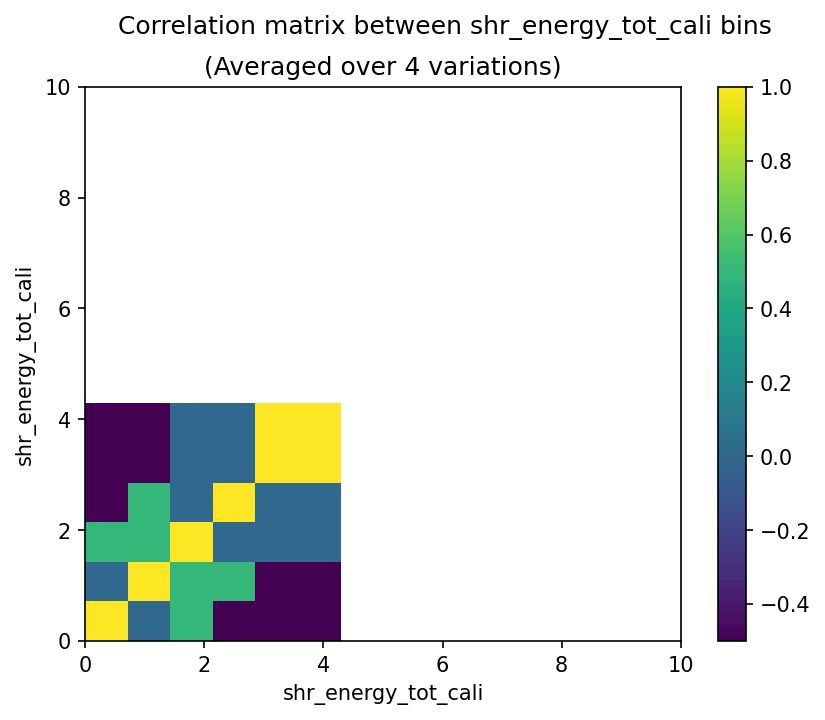

In [29]:
# Plot the correlation matrix

fig, ax = plt.subplots(dpi=150)

x = matrix_bin_centers
y = matrix_bin_centers
z = matrix

colormesh = ax.pcolormesh(x,y,z)
# colormesh = ax.pcolormesh(x,y,z, norm=mpl.colors.SymLogNorm(0.1))

ax.set_xlabel(f'{var}')
ax.set_ylabel(f'{var}')
fig.suptitle(f'Correlation matrix between {var} bins')
ax.set_title(f'(Averaged over {num_variations} variations)')

fig.colorbar(colormesh)

## Misclassification Matrices between Variations and Variables
Miscut/Misclassification is the term I am using to designate when one event behaves differently on a specific cut when compared between a DetVar and CV

In [30]:
# Function to determine whether a point is within/outside of the limits in both values -> bool
#  returns false if value1 and value2 either both pass or both fail a cut
#  return true otherwise

def is_misclassified(value1, value2, limits, tag='<'):
    if len(limits) == 1 and tag != '=':
        return ((value1 < limits[0]) ^ (value2 < limits[0]))
            
    elif len(limits) ==1 and tag == '=':
        return ((value1 == limits[0]) ^ (value2 == limits[0]))
        
    elif len(limits) == 2: # Assumes the cut is between the two
        return (((value1 < limits[0]) ^ (value1 < limits[1])) ^ ((value2 < limits[0]) ^ (value2 < limits[1])))
        
    elif len(limits) == 0:
        return np.zeros(len(cv), dtype=bool)
    
    else:
        raise ValueError("limits must have only 0, 1 or 2 values")

In [31]:
# Miscut Matrix and DataFrame

df_event_run_errors = pd.DataFrame(index=df_list[-1].index) # DataFrame to store miscut rates
df_event_run_errors['total'] = 0

miscut_matrix = np.zeros((len(var_bounds.keys()), len(df_list)-1))

for i, key in zip(range(len(var_bounds.keys())), var_bounds.keys()):
    limits = var_bounds[key]['limits']
    limit_tag = var_bounds[key]['limit_tag']
    
    df_event_run_errors[key] = 0
    
    for j in range(len(df_list)-1):
        
        df_event_run_errors[variation_titles[j]] = 0
        
        cv = np.array(df_list[-1].loc[shared_index[j]][key])
        detvar = np.array(df_list[j].loc[shared_index[j]][key])
        
        miscuts = is_misclassified(cv, detvar, limits, limit_tag).astype(int)
        
        miscut_matrix[i][j] += sum(miscuts)/len(miscuts)
        
        df_event_run_errors[key].loc[shared_index[j]] += miscuts
        df_event_run_errors['total'].loc[shared_index[j]] += 1
        df_event_run_errors[variation_titles[j]].loc[shared_index[j]] += miscuts
        
# combine across the different cut variables (to get a more resolved notion of how often events are misclassified)
df_event_run_errors['combined'] = df_event_run_errors.loc[:,var_bounds.keys()].sum(1)
df_event_run_errors['combined ratio'] = df_event_run_errors['combined'] / df_event_run_errors['total']
        
# print(df_event_run_errors.describe())
# print(miscut_matrix)

Text(0.5, 0.98, 'Misclassification Rate\n(Fraction of Events Cut Differently in CV and DetVar)')

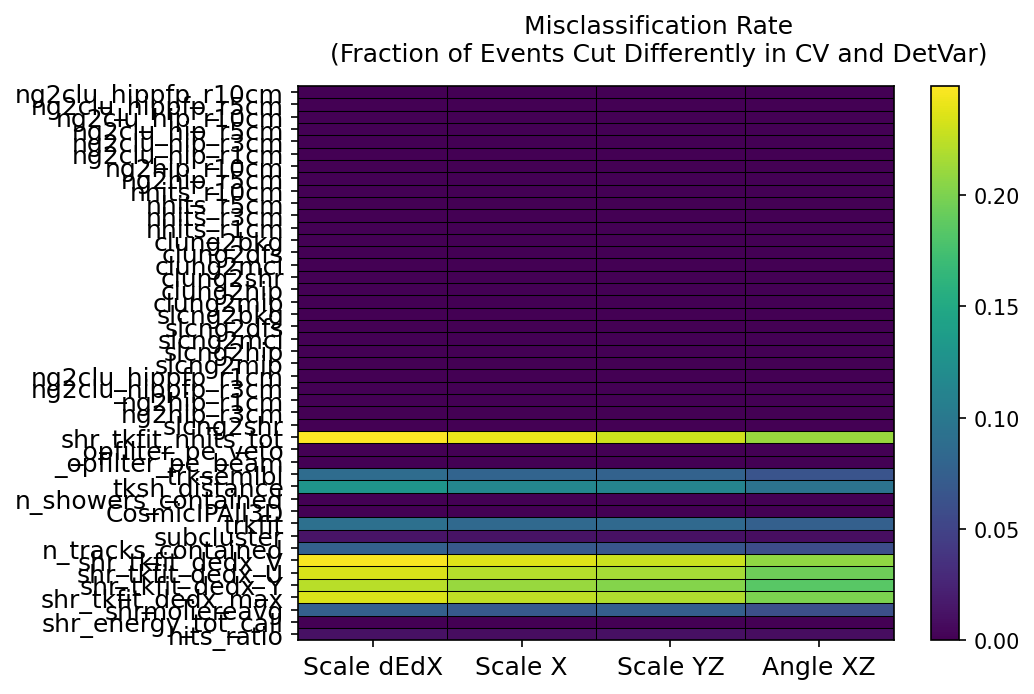

In [32]:
# Plot a 2d color mesh for the miscut matrix

fig, ax = plt.subplots(dpi=150)

x = np.arange(0,np.size(miscut_matrix, 1),1)
y = np.arange(0,np.size(miscut_matrix, 0),1)
z = miscut_matrix

colormesh = ax.pcolormesh(x,y,z)

ax.set_xticks(x)
ax.set_xticklabels(plot_labels[:-1], fontsize=12) #,rotation=45, ha='right')
ax.set_yticks(y)
ax.set_yticklabels(var_bounds.keys(), fontsize=12)

# Add black lines
for i in x[1:]:
    ax.axvline(x[i]-0.5, color='k', linewidth=0.5)
for i in y[1:]:
    ax.axhline(y[i]-0.5, color='k', linewidth=0.5)

fig.colorbar(colormesh)
fig.suptitle('Misclassification Rate\n(Fraction of Events Cut Differently in CV and DetVar)')

In [33]:
# Function to plot the correlation matrix based on desired ordering and filtering
#  index should be a single index (set of events) that are included
def calculate_correlation_matrix(index, variable_list, variation_list, invert_order=False):

    num_variables = len(variable_list)
    num_variations = len(variation_list)

    correlation_matrix = np.zeros((num_variables * num_variations, num_variables * num_variations))

    cv = df_list[-1].loc[index]

    labels = []
    
    # We need every pair of (variable + variation combination)
    #  var = variable (i, k)
    #  detvar = variation (j, l)
    
    if not invert_order:
        
        # Normal Ordering
        for i, var_i in enumerate(variable_list):
            limits_i = var_bounds[var_i]['limits']
            limit_tag_i = var_bounds[var_i]['limit_tag']
            cv_array_i = np.array(cv[var_i])

            for j, detvar_j in enumerate(variation_list):
                detvar_array_j = np.array(df_list[j].loc[index][var_i])

                index_ij = i*num_variations + j
                labels.append(f'{i}, {j}')

                for k, var_k in enumerate(variable_list):
                    limits_k = var_bounds[var_k]['limits']
                    limit_tag_k = var_bounds[var_k]['limit_tag']
                    cv_array_k = np.array(cv[var_k])

                    for l, detvar_l in enumerate(variation_list):
                        detvar_array_l = np.array(df_list[l].loc[index][var_k])

                        index_kl = k*num_variations + l

                        # Now that we have collected all of the required data, we perform the misclassification calculation and map
                        # the result to -1 (CV and DetVar have the same value) or +1 (CV and DetVar have different values)
                        # Then we multiply the results from the two DetVar together and the mean of this array is the correlation

                        misclassified_ij = is_misclassified(cv_array_i, detvar_array_j, limits_i, limit_tag_i).astype(int) * 2 - 1
                        misclassified_kl = is_misclassified(cv_array_k, detvar_array_l, limits_k, limit_tag_k).astype(int) * 2 - 1

                        correlation_ijkl = np.mean(misclassified_ij * misclassified_kl)

                        correlation_matrix[index_ij][index_kl] = correlation_ijkl
        
    else:
        
        # Inverted Ordering
        
        for j, detvar_j in enumerate(variation_list):
            for i, var_i in enumerate(variable_list):
                detvar_array_j = np.array(df_list[j].loc[index][var_i])    

                limits_i = var_bounds[var_i]['limits']
                limit_tag_i = var_bounds[var_i]['limit_tag']
                cv_array_i = np.array(cv[var_i])

                index_ij = j*num_variables + i
                labels.append(f'{i}, {j}')

                for l, detvar_l in enumerate(variation_list):
                    for k, var_k in enumerate(variable_list):
                        detvar_array_l = np.array(df_list[l].loc[index][var_k])

                        limits_k = var_bounds[var_k]['limits']
                        limit_tag_k = var_bounds[var_k]['limit_tag']
                        cv_array_k = np.array(cv[var_k])

                        index_kl = l*num_variables + k

                        misclassified_ij = is_misclassified(cv_array_i, detvar_array_j, limits_i, limit_tag_i).astype(int) * 2 - 1
                        misclassified_kl = is_misclassified(cv_array_k, detvar_array_l, limits_k, limit_tag_k).astype(int) * 2 - 1

                        correlation_ijkl = np.mean(misclassified_ij * misclassified_kl)

                        correlation_matrix[index_ij][index_kl] = correlation_ijkl
                        
    return correlation_matrix, labels

In [34]:
# Generate the correlation matrix

# variable_list = list(var_bounds.keys())
variable_list = ['shrmoliereavg', 'n_tracks_contained', 'shr_tkfit_dedx_max', 'trkfit', 'tksh_distance', 'trksemlbl', 'shr_tkfit_nhits_tot']
# variable_list.extend(nugraph_variables)

variation_list = plot_labels[:-1]
# variation_list = plot_labels[1:2]

invert_order = False

correlation_matrix, labels = calculate_correlation_matrix(pre_shared_index_all, variable_list, variation_list, invert_order=invert_order)


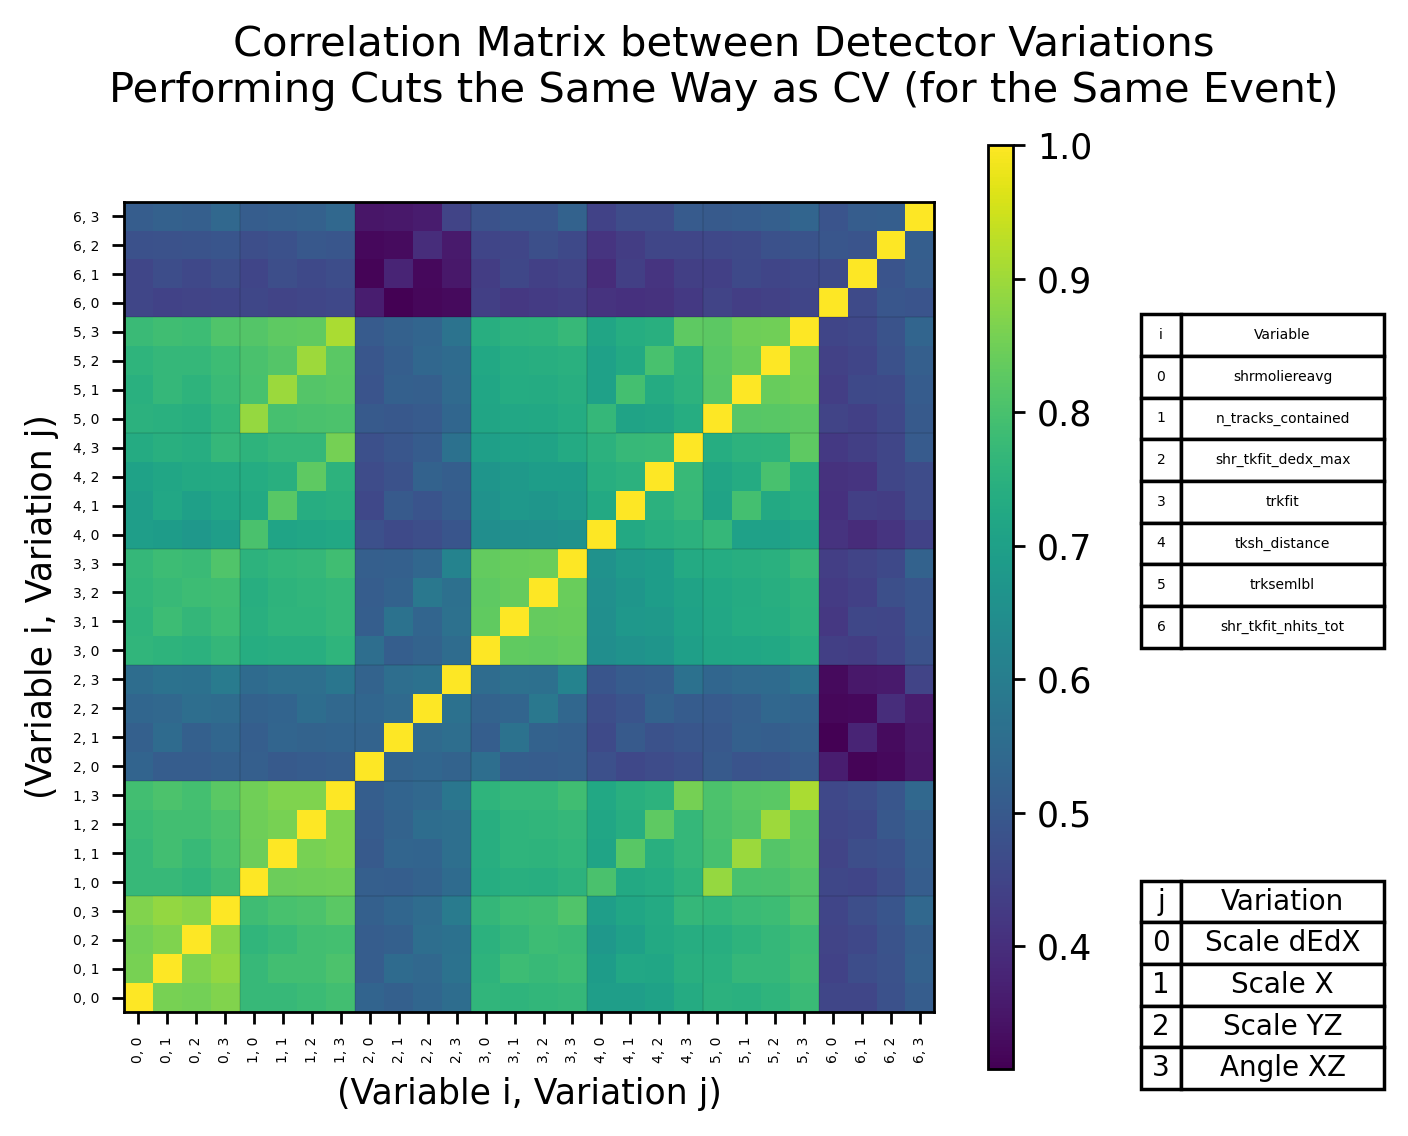

In [35]:
# Plot a 2d color mesh for the correlation matrix

fig = plt.figure(dpi=250)
gs = mpl.gridspec.GridSpec(2,4, width_ratios=[1, 0.03, 0.05, 0.25], height_ratios=[0.8, 0.2], wspace=0.2, hspace=0.2)

# Create the correlation matrix
ax_matrix = fig.add_subplot(gs[:,0])
ax_matrix.set_aspect('equal')

x = np.arange(0,np.size(correlation_matrix, 1),1)
y = np.arange(0,np.size(correlation_matrix, 0),1)
z = correlation_matrix

colormesh = ax_matrix.pcolormesh(x,y,z)

# Set the ticks
ax_matrix.set_xticks(x)
ax_matrix.set_xticklabels(labels, fontsize=4,rotation=90)
ax_matrix.set_yticks(y)
ax_matrix.set_yticklabels(labels, fontsize=4)

# Add black lines
lines = np.arange(0,np.size(correlation_matrix, 1), len(variable_list if invert_order else variation_list)) - 0.5 # Change which list to match the 2nd loop

for line in lines:
    ax_matrix.axvline(line, color='k', linewidth=0.05, alpha=1)
    ax_matrix.axhline(line, color='k', linewidth=0.05, alpha=1)
    
ax_matrix.set_xlabel('(Variable i, Variation j)')
ax_matrix.set_ylabel('(Variable i, Variation j)')
    
# Create the color bar
ax_cbar = fig.add_subplot(gs[:, 1])  

fig.colorbar(colormesh, cax=ax_cbar)

# Create the variable table
ax_table_var = fig.add_subplot(gs[0, 3])
ax_table_var.axis('off')
df = pd.DataFrame({'i':range(len(variable_list)), 'Variable':variable_list})
table = ax_table_var.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

for row in range(len(df) + 1): # (+1 to include header row)
    table[(row, 0)].set_width(0.2)
    table[(row, 1)].set_width(1.0)

# Create the variation table
ax_table_detvar = fig.add_subplot(gs[1, 3])
ax_table_detvar.axis('off')
df = pd.DataFrame({'j':range(len(variation_list)), 'Variation':variation_list})
table = ax_table_detvar.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

for row in range(len(df) + 1):  # (+1 to include header row)
    table[(row, 0)].set_width(0.2)
    table[(row, 1)].set_width(1.0) 

fig.suptitle('Correlation Matrix between Detector Variations\nPerforming Cuts the Same Way as CV (for the Same Event)');

In [36]:
# Create a correlation matrix between the chosen variables (removes special values from all of them)

variable_list = ['shrmoliereavg', 'n_tracks_contained', 'shr_tkfit_dedx_max', 'trkfit', 'tksh_distance', 'trksemlbl', 'shr_tkfit_nhits_tot']
variable_list.extend(nugraph_variables[:])

variation_index = 0

num_variables = len(variable_list)

covariance_matrix = np.zeros((num_variables, num_variables))
correlation_matrix_2 = np.zeros((num_variables, num_variables))

for i, var_i in enumerate(variable_list):
    for j, var_j in enumerate(variable_list):
        
        index, index_all = filter_index(shared_index[:], shared_index_all, [var_i, var_j], variation_index=variation_index, exponent_threshold=7)
        
        detvar_i = np.array(df_list[variation_index].loc[index_all][var_i]) 
        detvar_j = np.array(df_list[variation_index].loc[index_all][var_j])
        
        # Use central value as the expected value
        cv_i = np.array(df_list[-1].loc[index_all, var_i]) 
        cv_j = np.array(df_list[-1].loc[index_all,var_j]) 
        
        mean = np.mean((detvar_i - cv_i)*(detvar_j - cv_j))
        
        covariance_matrix[i][j] = mean
        
for i in range(len(variable_list)):
    for j in range(len(variable_list)):
        correlation_matrix_2[i][j] = covariance_matrix[i][j] / np.sqrt(covariance_matrix[i][i] * covariance_matrix[j][j])
        
print(correlation_matrix_2)

print(np.all(correlation_matrix_2.transpose() == correlation_matrix_2))


/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


[[       nan 0.                nan ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.52311269 0.52352137 0.48549776]
 [       nan 0.                nan ... 0.         0.         0.        ]
 ...
 [0.         0.52311269 0.         ... 1.         0.95346407 0.82844493]
 [0.         0.52352137 0.         ... 0.95346407 1.         0.92504865]
 [0.         0.48549776 0.         ... 0.82844493 0.92504865 1.        ]]
False


/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


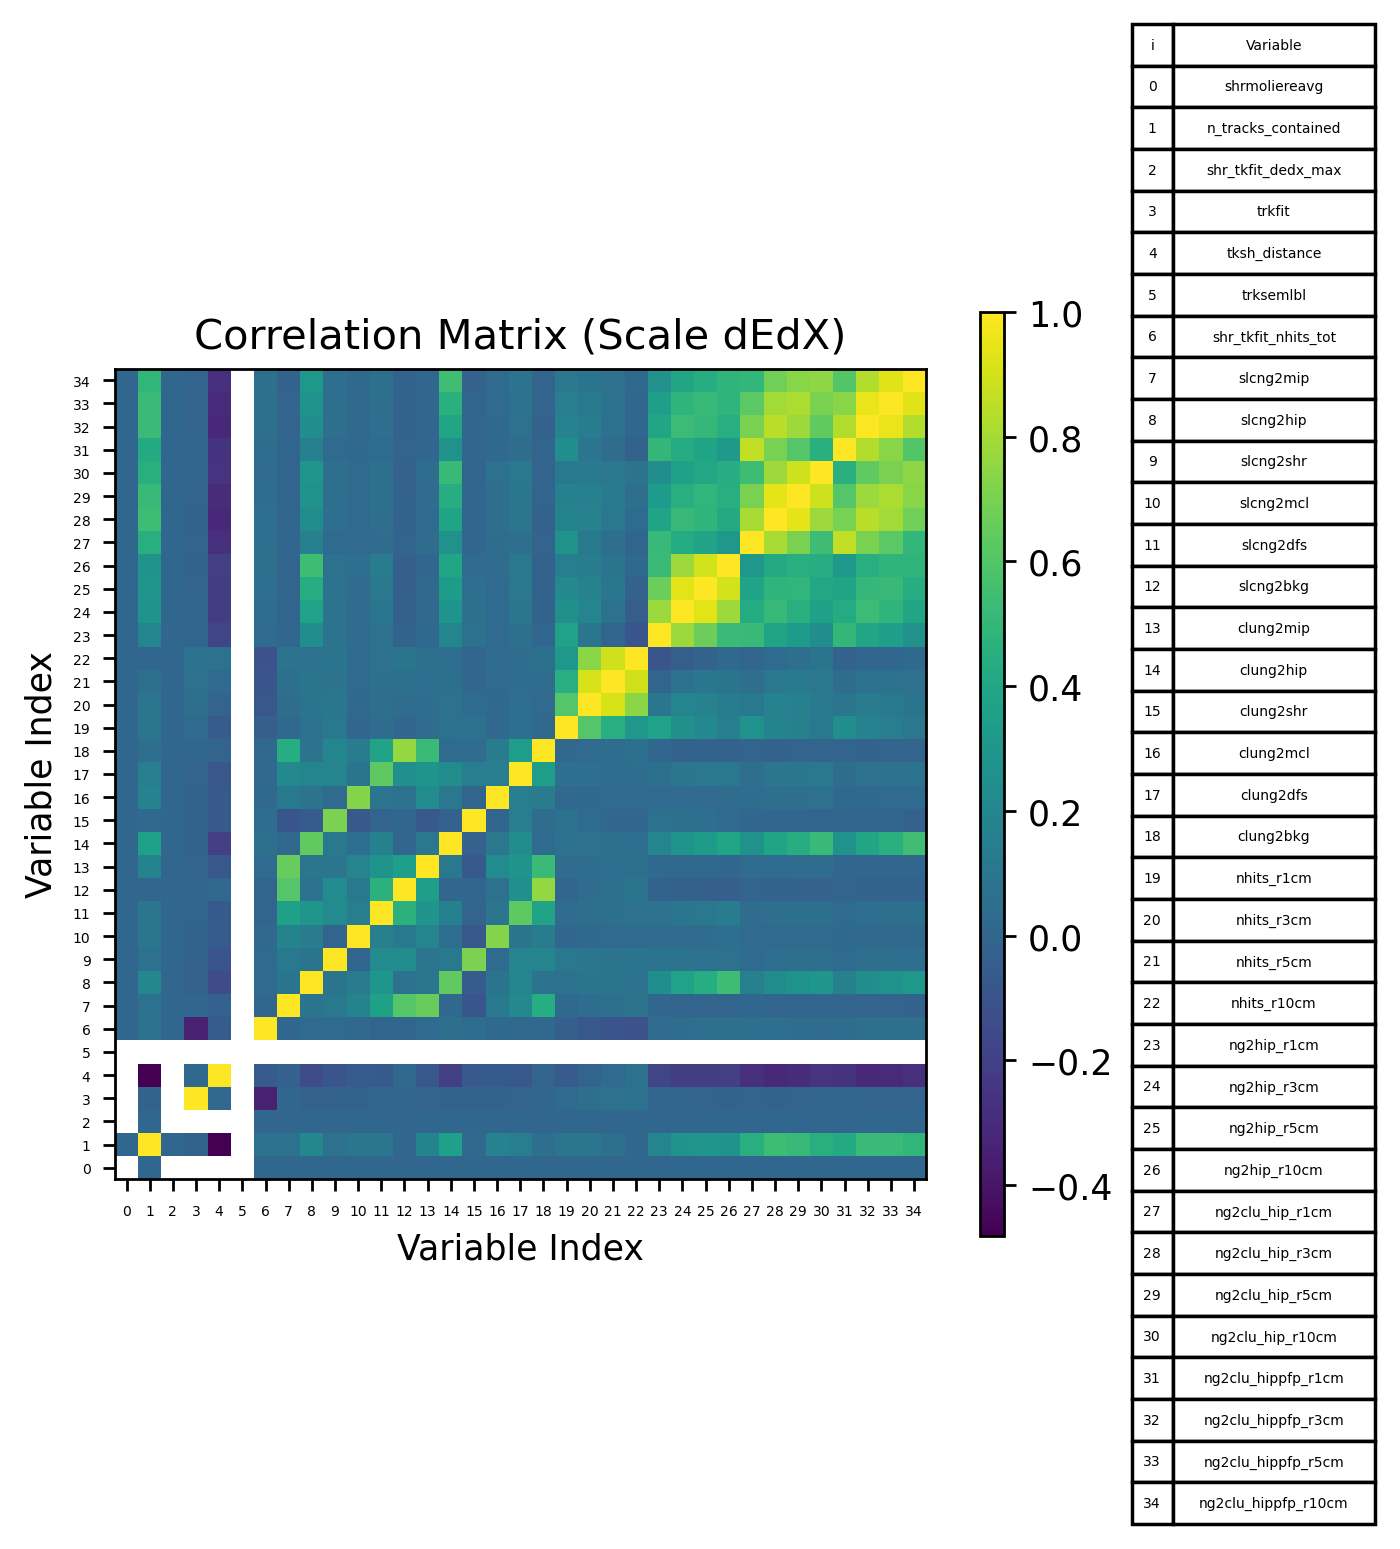

In [37]:
# Plot a 2d color mesh for the second correlation matrix

fig = plt.figure(dpi=250)
gs = mpl.gridspec.GridSpec(1,4, width_ratios=[1, 0.03, 0.05, 0.25], wspace=0.2, hspace=0.2)

# Create the correlation matrix
ax_matrix = fig.add_subplot(gs[:,0])
ax_matrix.set_aspect('equal')

x = np.arange(0,np.size(correlation_matrix_2, 1),1)
y = np.arange(0,np.size(correlation_matrix_2, 0),1)
z = correlation_matrix_2

colormesh = ax_matrix.pcolormesh(x,y,z)

# Set the ticks
ax_matrix.set_xticks(x)
ax_matrix.set_xticklabels(range(len(variable_list)), fontsize=4)
ax_matrix.set_yticks(y)
ax_matrix.set_yticklabels(range(len(variable_list)), fontsize=4)

ax_matrix.set_xlabel('Variable Index')
ax_matrix.set_ylabel('Variable Index')
    
# Create the color bar
ax_cbar = fig.add_subplot(gs[:, 1])  

fig.colorbar(colormesh, cax=ax_cbar)

# Create the variable table
ax_table_var = fig.add_subplot(gs[:, 3])
ax_table_var.axis('off')
df = pd.DataFrame({'i':range(len(variable_list)), 'Variable':variable_list})
table = ax_table_var.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

for row in range(len(df) + 1): # (+1 to include header row)
    table[(row, 0)].set_width(0.2)
    table[(row, 1)].set_width(1.0)

ax_matrix.set_title(f'Correlation Matrix ({plot_labels[variation_index]})');

## Picking out events to look at EventDisplay

In [38]:
selection_var = 'shr_tkfit_dedx_max'
selection_variation_index = 1

# Configuration of selection (set to None if unused)
cv_target = 2 
cv_extreme = None
detvar_target = None
detvar_extreme = 6
buffer = 0.25 # Buffer region around the target (must exist if either target is active)

selection_title = f"Selection on {selection_var}: "
if cv_target:
    selection_title += f'\n = {cv_target} ± {buffer} in CV'
    
if cv_extreme:
    selection_title += f'\n > {cv_extreme} in CV'
    
if detvar_target:
    selection_title += f'\n = {detvar_target} ± {buffer} in {variation_titles[selection_variation_index]}'
    
if detvar_extreme:
    selection_title += f'\n > {detvar_extreme} in {variation_titles[selection_variation_index]}'
    
print(selection_title)

df_detvar = df_list[selection_variation_index].loc[shared_index_all] # Start with the list of all of the events shared with all variations
df_cv = df_list[-1].loc[shared_index_all]

# Filter the dataframes to just the events within the target region
if cv_target:
    df_cv = df_cv[(df_cv[selection_var] > cv_target - buffer) & (df_cv[selection_var] < cv_target + buffer)]
if detvar_target:
    df_detvar = df_detvar[(df_detvar[selection_var] > detvar_target - buffer) & (df_detvar[selection_var] < detvar_target + buffer)]

# Filter the dataframes to just the events above the extremes
if cv_extreme:
    df_cv = df_cv[df_cv[selection_var] > cv_extreme]
if detvar_extreme:
    df_detvar = df_detvar[df_detvar[selection_var] > detvar_extreme]

# filter_index = ((df_detvar[selection_var] - df_cv[selection_var] > difference) | (df_detvar[selection_var] - df_cv[selection_var] < -difference))

target_index = df_detvar.index.intersection(df_cv.index)
# target_index = target_index.intersection(temp3)

print(df_cv.loc[target_index, ['evt', 'run', 'sub', selection_var]])

print(f'Selecting randomly from {len(target_index)} candidates')

random_index = random.randint(0,len(target_index)-1)

df_variations = pd.DataFrame(columns=list(df_cv.columns) + ['variation'])
for i in range(len(df_list)):
    
    df = df_list[i].loc[target_index]
    
    df = df.iloc[[random_index]]
    
    df['variation'] = variation_titles[i]
    
#     df_variations = df
    df_variations = df_variations.append(df, ignore_index=True)
    
df_variations = df_variations.set_index('variation')

print(df_variations.loc[:,['evt', 'run', 'sub', selection_var]])

Selection on shr_tkfit_dedx_max: 
 = 2 ± 0.25 in CV
 > 6 in wiremod_ScaleX
               evt   run   sub  shr_tkfit_dedx_max
ident_id                                          
-1582306463   8129  7006   162            2.088748
-1575824138  20454  7010   409            2.062286
 2057263883   1179  6352    23            1.789645
-2122371771   2821  6467    56            2.202602
 1611907082   4378  5906    87            1.943617
...            ...   ...   ...                 ...
 1139329161   6457  5433   129            2.180246
-1571954906  49686  7008   993            1.967919
-1567402199  62393  7010  1247            2.193628
-1575864332  20260  7010   405            1.969100
 2005082975    271  6300     5            2.027354

[226 rows x 4 columns]
Selecting randomly from 226 candidates
                    evt   run  sub  shr_tkfit_dedx_max
variation                                             
wiremod_ScaledEdX  7567  6922  151            1.905676
wiremod_ScaleX     7567  6922  151

In [39]:
# Get the values for a certain event, run, sub combination

evt = 22297
run = 7008
subrun = None

df_variations = pd.DataFrame(columns=list(df_cv.columns) + ['variation'])
for i in range(len(df_list)):
    
    df = df_list[i]
    
    if evt:
        df = df[df['evt'] == evt]
    if run:
        df = df[df['run'] == run]
    if subrun:
        df = df[df['sub'] == subrun]
    
    df['variation'] = variation_titles[i]
    df_variations = df_variations.append(df, ignore_index=True)
    
df_variations = df_variations.set_index('variation')

print(df_variations.loc[:,['evt', 'run', 'sub', selection_var]])

                     evt   run  sub  shr_tkfit_dedx_max
variation                                              
wiremod_ScaledEdX  22297  7008  445            6.111948
wiremod_ScaleX     22297  7008  445            1.930679
wiremod_ScaleYZ    22297  7008  445            6.564722
WireModAngleXZ     22297  7008  445            6.599526
CV                 22297  7008  445            6.860847


## Preselection and Cut Efficiency Plots

In [40]:
# Define binning
cut_bins = np.linspace(0,2.5,20)
cut_bin_centers = (cut_bins[:-1]+cut_bins[1:])/2
cut_bin_width = cut_bins[1]-cut_bins[0]

In [41]:
def plot_cut_efficiency(before_index, after_index, bins, ylabel, title, subtitle = None, dpi=150, legend_loc='best'):
    
    bin_centers = (bins[:-1]+bins[1:])/2
    bin_width = bins[1]-bins[0]
    
    # Allow passing a single index by duplicating it for each variation
    if len(before_index) == 1:
        before_index = [before_index for _ in df_list]
    if len(after_index) == 1:
        after_index = [after_index for _ in df_list]
    
    fig = plt.figure(dpi=dpi)
    gs = mpl.gridspec.GridSpec(2,1, height_ratios=[0.8, 0.2], wspace=0.2, hspace=0.1)

    cut_ax = fig.add_subplot(gs[0,:])
    ratio_ax = fig.add_subplot(gs[1,:])

    # Store cut efficiencies and standard errors to get the ratio in a second for-loop
    cut_efficiencies = []
    proportion_errors = []

    # Create the upper plot with the cut efficiencies
    for i in range(len(df_list)):

        before_hist = np.histogram(df_list[i].loc[before_index[i], ['elec_e']].to_numpy(), bins)[0]
        after_hist = np.histogram(df_list[i].loc[after_index[i], ['elec_e']].to_numpy(), bins)[0]

        cut_efficiency = after_hist/before_hist
        cut_efficiencies.append(cut_efficiency)

        proportion_error = np.sqrt(cut_efficiency*(1-cut_efficiency)/before_hist) # Standard error for a proportion
        proportion_errors.append(proportion_error)

        cut_ax.errorbar(bin_centers, cut_efficiency,xerr=bin_width/2, yerr=proportion_error, 
                                   ls='none',marker='s',ms=2.5,lw=1,
                                   label=f'{plot_labels[i]}')

    # Create the lower plot for ratios with CV
    for i in range(len(df_list)-1):
        
        ratio = cut_efficiencies[i]/cut_efficiencies[-1]
        division_error = np.sqrt(proportion_errors[i]*proportion_errors[i]/cut_efficiencies[-1] + 
                                 proportion_errors[-1]*proportion_errors[-1]/cut_efficiencies[i]) # Propagated uncertainty for division
        
        ratio_ax.errorbar(bin_centers, ratio,xerr=bin_width/2, yerr = division_error,
                       ls='none',marker='s',ms=2.5,lw=1)

    ratio_ax.axhline(1, ls='-', color='k', linewidth=1) # Horizontal line for CV
    
    # Axis formatting
    cut_ax.set_xlim(min(bins),max(bins))
    cut_ax.set_ylim(0,1)
    cut_ax.set_ylabel(ylabel)
    cut_ax.set_xticks([])
    cut_ax.legend(loc=legend_loc)
    if subtitle:
        cut_ax.set_title(subtitle)

    ratio_ax.set_xlim(min(bins),max(bins))
    ratio_ax.set_ylabel('Ratio w.r.t CV')
    ratio_ax.set_xlabel('Electron Energy [GeV]')
    
    fig.suptitle(title)

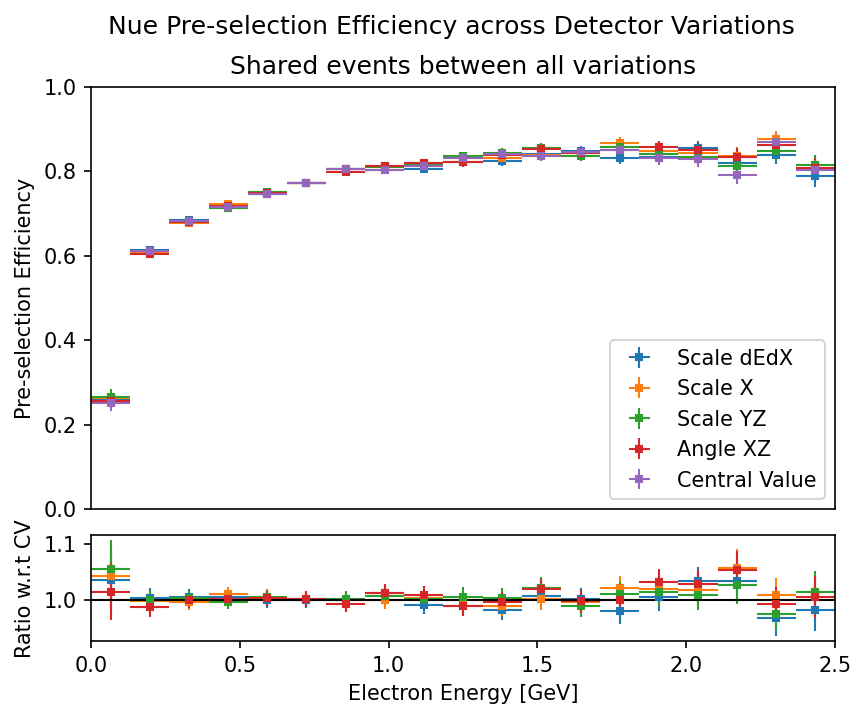

In [42]:
# Preselection
plot_cut_efficiency(before_intersected_index,
                    pre_intersected_index,
                    cut_bins, 
                    'Pre-selection Efficiency',
                    f'Nue Pre-selection Efficiency across Detector Variations',
                   subtitle=f'Shared events between all variations')

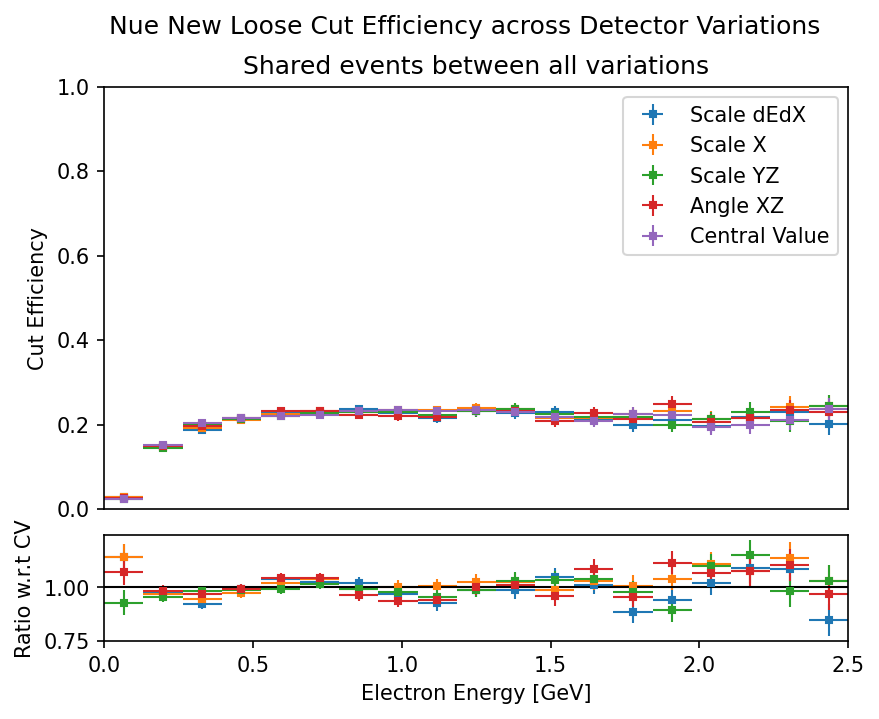

In [43]:
# New Loose Cuts
plot_cut_efficiency(before_intersected_index,
                    cut_intersected_index,
                    cut_bins, 
                    'Cut Efficiency',
                    f'Nue New Loose Cut Efficiency across Detector Variations',
                   subtitle=f'Shared events between all variations')

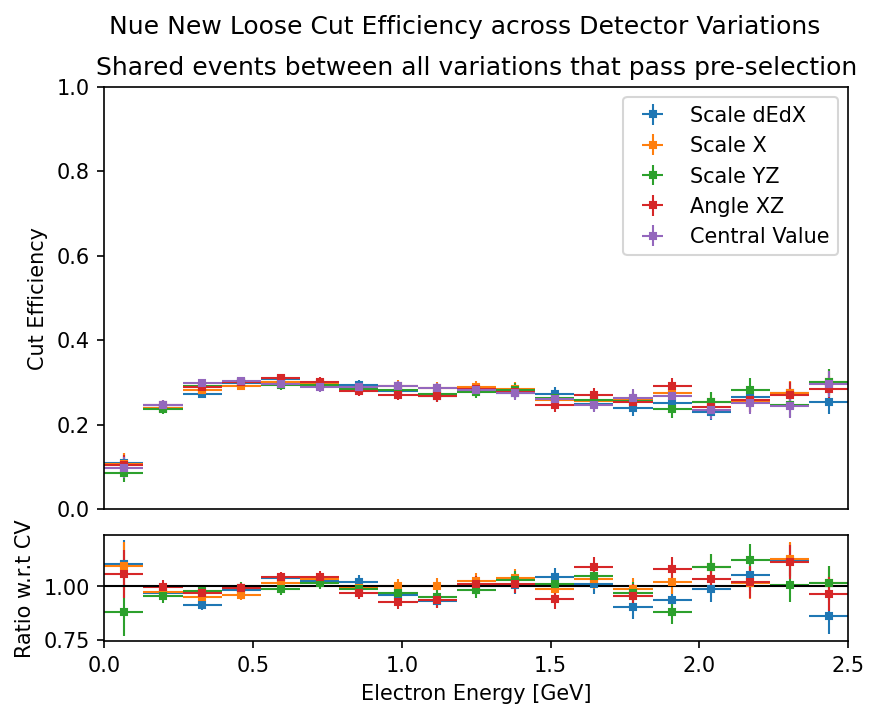

In [44]:
# New Loose Cuts (only events that pass pre-selection)
plot_cut_efficiency(pre_intersected_index,
                    cut_intersected_index,
                    cut_bins, 
                    'Cut Efficiency',
                    f'Nue New Loose Cut Efficiency across Detector Variations',
                   subtitle=f'Shared events between all variations that pass pre-selection')

## Plotting single variable across one variation

In [150]:
# selection_vars = ['slcng2mip', 'slcng2hip', 'slcng2shr']
# selection_var_total = 'slcng2_total'
# selection_variation_index = 1
# selection_name = 'Proportion of Hits in Semantic Label'
# selection_shorthand = 'slcng2'
# selection_bin_max = 1
# selection_num_bins = 20

# selection_vars = ['clung2mip', 'clung2hip', 'clung2shr']
# selection_var_total = 'clung2_total'
# selection_variation_index = 1
# selection_name = 'Proportion of Clustered Hits in Semantic Label'
# selection_shorthand = 'clung2'
# selection_bin_max = 1
# selection_num_bins = 20

# selection_vars = ['nhits_r1cm', 'nhits_r3cm', 'nhits_r5cm', 'nhits_r10cm']
# selection_var_total = None
# selection_variation_index = 1
# selection_name = 'Number of Hits within Radius'
# selection_shorthand = 'nhit_rXcm'
# selection_bin_max = 400
# selection_num_bins = 20


# selection_vars = ['ng2hip_r1cm', 'ng2hip_r3cm', 'ng2hip_r5cm', 'ng2hip_r10cm']
# selection_var_total = None
# selection_variation_index = 1
# selection_name = 'Number of HIP Hits within Radius'
# selection_shorthand = 'ng2hip_rXcm'
# selection_bin_max = 200
# selection_num_bins = 20

selection_vars = ['ng2hip_r1cm', 'ng2hip_r3cm', 'ng2hip_r5cm', 'ng2hip_r10cm']
selection_var_total = 'slcng2hip'
selection_variation_index = 1
selection_name = 'Proportion of HIP Hits within Radius'
selection_shorthand = 'ng2hip_rXcm/slcng2hip'
selection_bin_max = 1
selection_num_bins = 20

# selection_vars = ['ng2clu_hip_r1cm', 'ng2clu_hip_r3cm', 'ng2clu_hip_r5cm', 'ng2clu_hip_r10cm']
# selection_var_total = None
# selection_variation_index = 1
# selection_name = 'Number of HIP Hits within Radius (Clustered in PFPs)'
# selection_shorthand = 'ng2clu_hip_rXcm'
# selection_bin_max = 200
# selection_num_bins = 20

# selection_vars = ['ng2clu_hippfp_r1cm', 'ng2clu_hippfp_r3cm', 'ng2clu_hippfp_r5cm', 'ng2clu_hippfp_r10cm']
# selection_var_total = None
# selection_variation_index = 1
# selection_name = 'Number of HIP Hits within Radius (Clustered in HIP-labeled PFPs)'
# selection_shorthand = 'ng2clu_hippfp_rXcm'
# selection_bin_max = 200
# selection_num_bins = 20

/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/gkunkler/miniconda3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


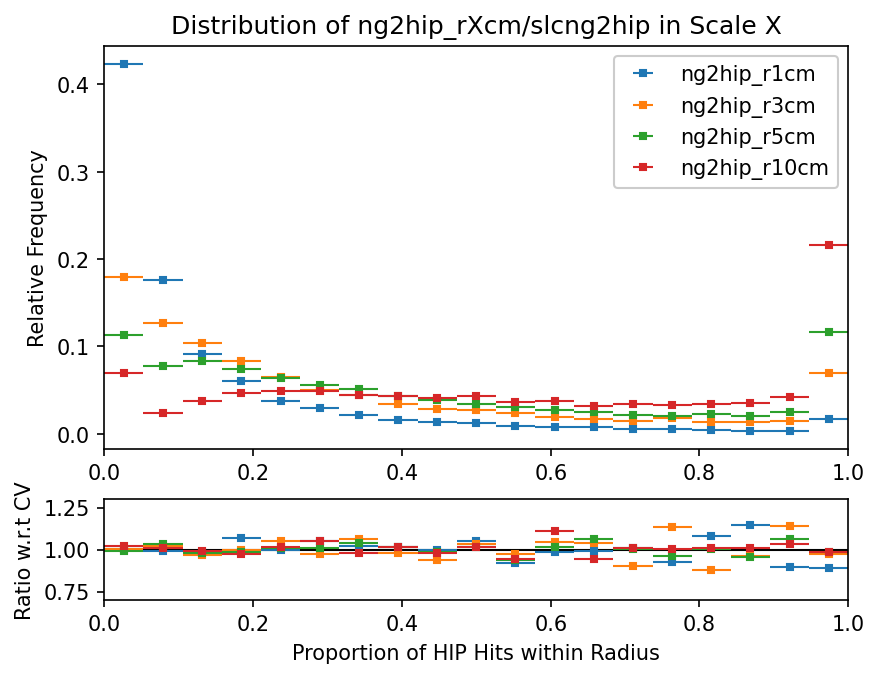

In [151]:
multi_bins = np.linspace(0,selection_bin_max,selection_num_bins)
multi_bin_centers = (multi_bins[:-1]+multi_bins[1:])/2
multi_bin_width = multi_bins[1]-multi_bins[0]
multi_limits = []

_, index_all = filter_index(shared_index, shared_index_all, selection_vars)

if selection_var_total:

    totals = np.array(df_list[selection_variation_index].loc[index_all][selection_var_total])
    cv_totals = np.array(df_list[-1].loc[index_all][selection_var_total])

fig = plt.figure(dpi=150)

gs = mpl.gridspec.GridSpec(2,1, height_ratios=[0.8, 0.2], wspace=0.2, hspace=0.2)

lines_ax = fig.add_subplot(gs[0,:])
ratio_ax = fig.add_subplot(gs[1,:])

ratio_ax.axhline(1, ls='-', c='k', linewidth=1)    
    
for var_temp in selection_vars:
    
    values = np.array(df_list[selection_variation_index].loc[index_all][var_temp])
    cv_values = np.array(df_list[-1].loc[index_all][var_temp])
    
    if selection_var_total:
    
        rel_freq = get_rel_frequencies(values/totals, multi_bins)
        cv_rel_freq = get_rel_frequencies(cv_values/cv_totals, multi_bins)
        
    else:
        
        rel_freq = get_rel_frequencies(values, multi_bins)
        cv_rel_freq = get_rel_frequencies(cv_values, multi_bins)
    
    lines_ax.errorbar(multi_bin_centers,rel_freq,xerr=multi_bin_width/2,ls='none',marker='s',ms=2.5,lw=1, label=var_temp) # Without error bars
    
    ratio_ax.errorbar(multi_bin_centers,rel_freq/cv_rel_freq,xerr=multi_bin_width/2, ls='none',marker='s',ms=2.5,lw=1)
    
for limit in multi_limits: 
    lines_ax.axvline(limit, ls=':',c='k') #, label=f'{var} limit')
    

ratio_ax.set_ylabel('Ratio w.r.t CV')
ratio_ax.set_xlim(min(multi_bins), max(multi_bins))
ratio_ax.set_ylim(0.7, 1.3)

    
lines_ax.legend(framealpha=1)
lines_ax.set_xlim(min(multi_bins), max(multi_bins))
lines_ax.set_title(f'Distribution of {selection_shorthand} in {plot_labels[selection_variation_index]}')
lines_ax.set_ylabel('Relative Frequency')
ratio_ax.set_xlabel(selection_name);

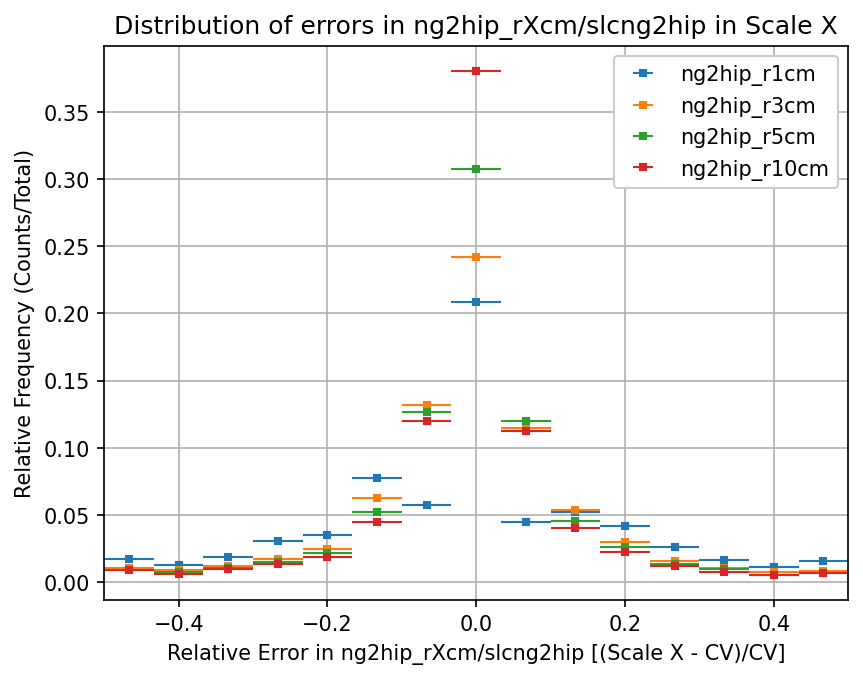

In [165]:
multi_err_bins = np.linspace(-0.5,0.5,16)
multi_err_bin_centers = (multi_err_bins[:-1]+multi_err_bins[1:])/2
multi_err_bin_width = multi_err_bins[1]-multi_err_bins[0]

err_fig, err_ax = plt.subplots(dpi=150)
    
for var_temp in selection_vars:
    
    detvar = df_list[selection_variation_index].loc[shared_index[selection_variation_index]][var_temp]
    cv = df_list[-1].loc[shared_index[selection_variation_index]][var_temp]
    
    relative_error = ( detvar - cv ) / cv
    
    hist = get_rel_frequencies(relative_error, multi_err_bins)
    
    err_ax.errorbar(multi_err_bin_centers,hist,xerr=multi_err_bin_width/2,ls='none',marker='s',ms=2.5,lw=1,label=var_temp)
    
err_ax.grid(True)
err_ax.legend(framealpha=1)
err_ax.set_xlim(min(multi_err_bins), max(multi_err_bins))
err_ax.set_title(f'Distribution of errors in {selection_shorthand} in {plot_labels[selection_variation_index]}')
err_ax.set_ylabel('Relative Frequency (Counts/Total)')
err_ax.set_xlabel(f'Relative Error in {selection_shorthand} [({plot_labels[selection_variation_index]} - CV)/CV]');

## Splitting Based on Coordinate Position

In [294]:
direction = 'true_nu_vtx_x'

if direction == 'true_nu_vtx_x':
    split_plane = 256/2
    split_bins = np.linspace(0,256,15)
elif direction == 'true_nu_vtx_y':
    split_plane = 0
    split_bins = np.linspace(-116,116,15)
elif direction == 'true_nu_vtx_z':
    split_plane = (1+1030)/2
    split_bins = np.linspace(1,1030,15)

split_bin_centers = (split_bins[:-1]+split_bins[1:])/2
split_bin_width = split_bins[1]-split_bins[0]


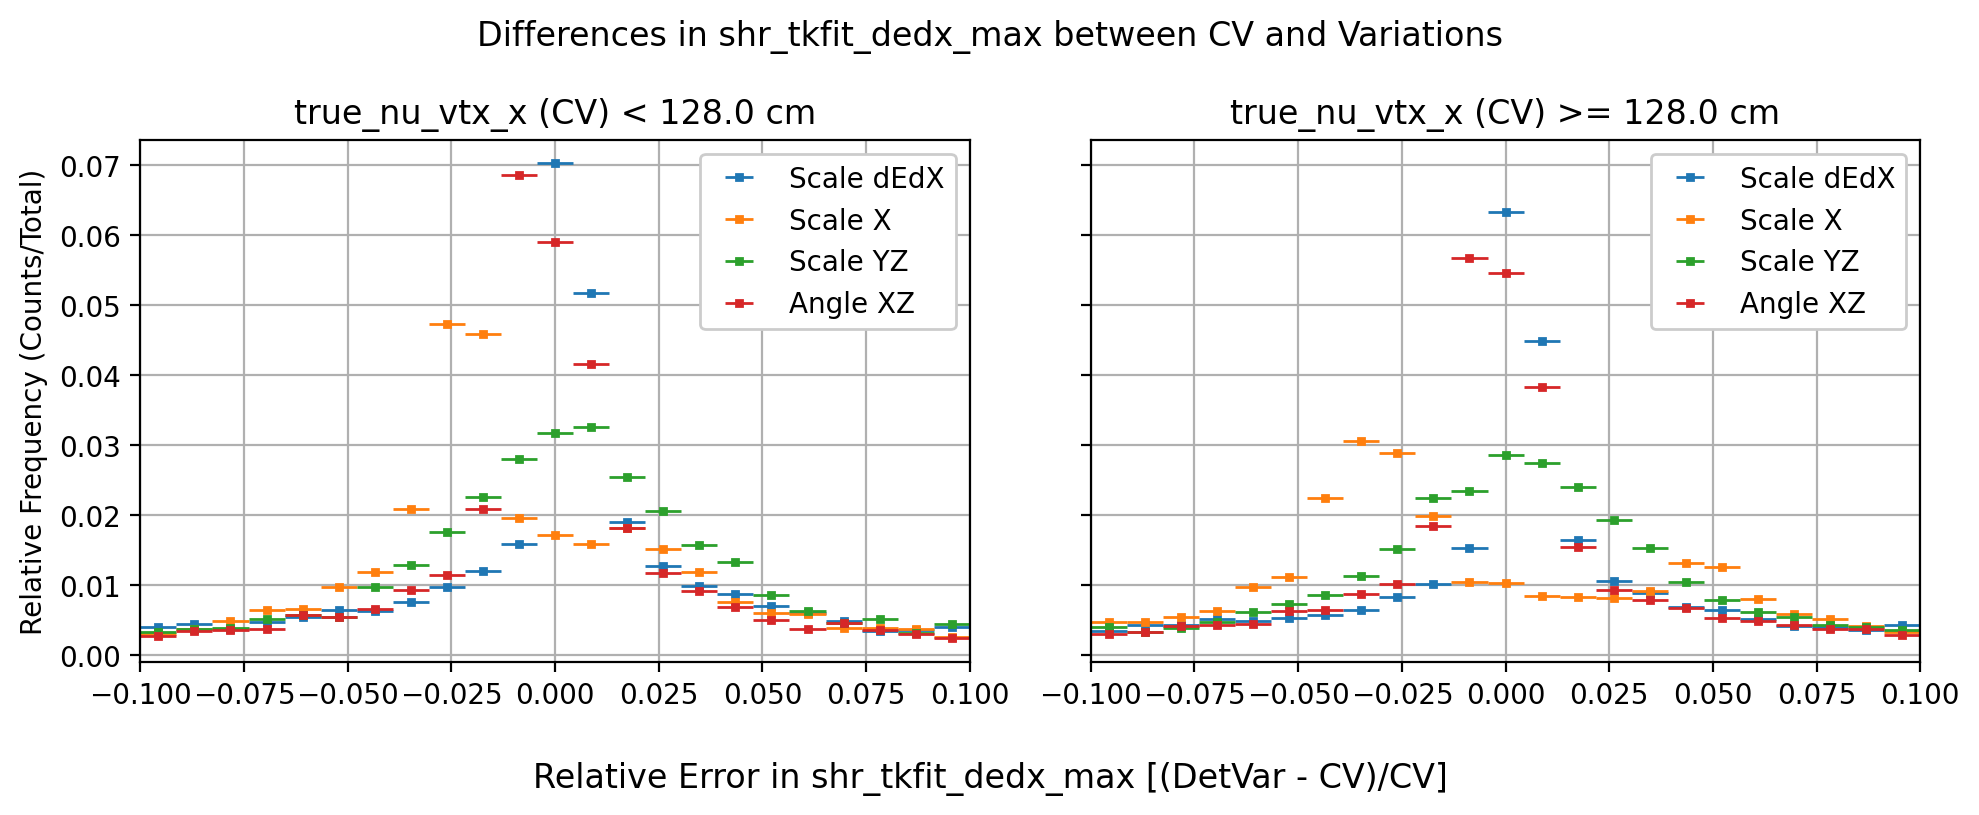

In [295]:
# Split just into two bins

fig, (less_ax, more_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4), dpi=200)

for i in range(len(df_list)-1):
    
    cv = df_list[-1].loc[filtered_shared_index[i]]
    less_index = cv[cv[direction] < split_plane].index
    more_index = cv[cv[direction] >= split_plane].index
    cv = cv[var]
    
    df = df_list[i].loc[filtered_shared_index[i]][var]
    df_less = df.loc[less_index]
    df_more = df.loc[more_index]

    less_rel_errors = ( df_less - cv ) / cv
    more_rel_errors = ( df_more - cv ) / cv
    
    hist = get_rel_frequencies(less_rel_errors, err_bins)
    less_ax.errorbar(err_bin_centers,hist,xerr=err_bin_width/2,ls='none',marker='s',ms=2.5,lw=1,label=plot_labels[i])
    
    hist = get_rel_frequencies(more_rel_errors, err_bins)
    more_ax.errorbar(err_bin_centers,hist,xerr=err_bin_width/2,ls='none',marker='s',ms=2.5,lw=1,label=plot_labels[i])
    
less_ax.grid(True)
more_ax.grid(True)
less_ax.legend(framealpha=1)
more_ax.legend(framealpha=1)
less_ax.set_xlim(min(err_bins), max(err_bins))
more_ax.set_xlim(min(err_bins), max(err_bins))
less_ax.set_title(f'{direction} (CV) < {split_plane} cm')
more_ax.set_title(f'{direction} (CV) >= {split_plane} cm')
less_ax.set_ylabel('Relative Frequency (Counts/Total)')
fig.supxlabel(f'Relative Error in {var} [(DetVar - CV)/CV]')
fig.suptitle(f'Differences in {var} between CV and Variations');

fig.tight_layout()


In [296]:


direction_index, direction_index_all = filter_index(pre_shared_index, pre_shared_index_all, [var], special=[special],exponent_threshold=5)
direction_index_all = filtered_shared_index_all

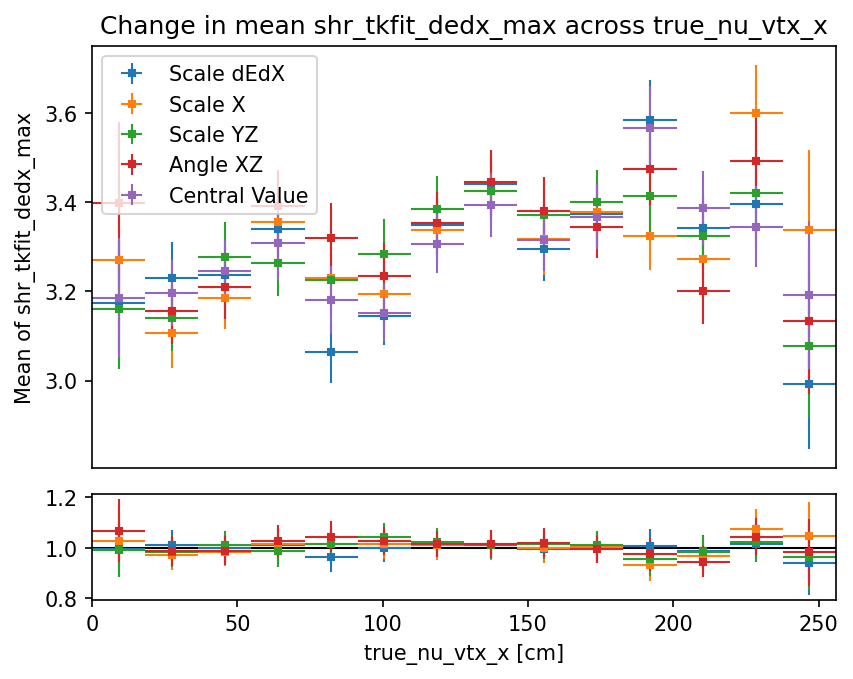

In [297]:
# Plot the mean of var based on the directional binning

fig = plt.figure(dpi=150)
gs = mpl.gridspec.GridSpec(2,1, height_ratios=[0.8, 0.2], wspace=0.2, hspace=0.1)

ax = fig.add_subplot(gs[0,:])
ratio_ax = fig.add_subplot(gs[1,:])

means = []
errors = []

for i in range(len(df_list)):
    
    df = df_list[i].loc[direction_index_all]
    
    df = df[df[var] > 0]
#     df = df[df[var] < 9999]
    
    cut = pd.cut(df[direction], split_bins)
    
    grouped = df[var].groupby(cut)
    
    mean = grouped.mean()
    std = grouped.std()
    counts = grouped.count()
    
    means.append(mean)
    errors.append(std/np.sqrt(counts))
    
    ax.errorbar(split_bin_centers,mean,xerr=split_bin_width/2,yerr=std/np.sqrt(counts), ls='none',marker='s',ms=2.5,lw=1,label=plot_labels[i])
    
ratio_ax.axhline(1, color='k', lw=1)    
    
for i in range(len(df_list)-1):
    
    combined_error = np.sqrt(errors[i]*errors[i]/means[-1] + errors[-1]*errors[-1]/means[i])
    
    ratio_ax.errorbar(split_bin_centers,means[i]/means[-1],xerr=split_bin_width/2,yerr=combined_error, ls='none',marker='s',ms=2.5,lw=1)
    
ax.set_xticks([])
ax.set_xlim(min(split_bins), max(split_bins))
ratio_ax.set_xlim(min(split_bins), max(split_bins))
ratio_ax.set_xlabel(f'{direction} [cm]')
ax.set_ylabel(f'Mean of {var}')
ax.set_title(f'Change in mean {var} across {direction}')
ax.legend()

## 2D Histograms between var and direction

In [304]:
selection_variation_index = 1

draw_box = True
# rel_errors_bounds = [0.04, 0.06]
# position_bounds = [100, 225]

rel_errors_bounds = [-0.04, -0.01]
position_bounds = [20, 225]

Text(0.5, 1.0, 'Relative Error Distribution as Detector Position Changes')

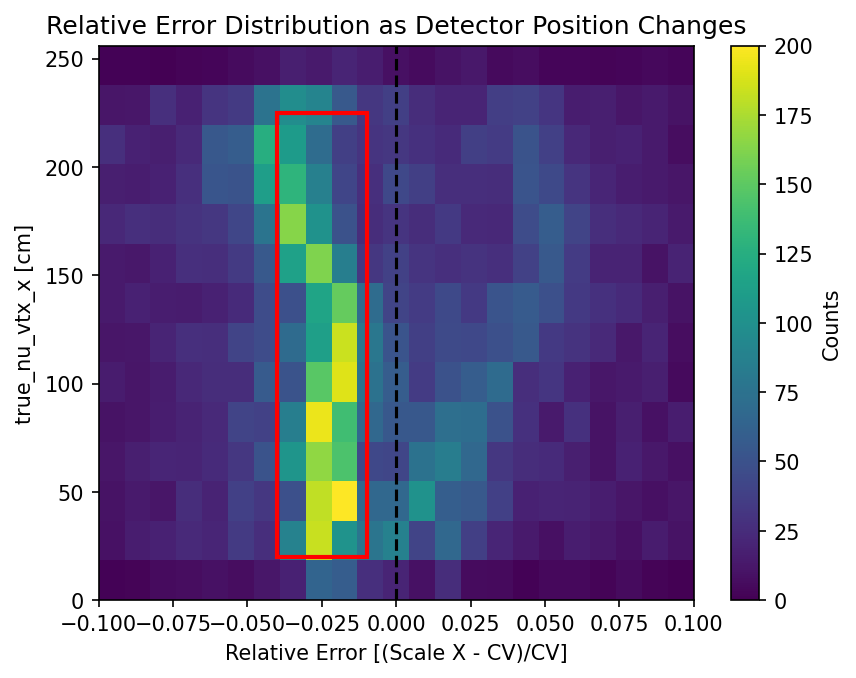

In [305]:
# 2d histogram for direction and rel error of var

df = df_list[selection_variation_index].loc[direction_index[selection_variation_index]]
cv = df_list[-1].loc[direction_index[selection_variation_index]]

values = df[var]
cv_values = cv[var]
positions = df[direction]

rel_errors = (values - cv_values) / cv_values

rel_error_index = rel_errors[(rel_errors > rel_errors_bounds[0]) & 
                             (rel_errors < rel_errors_bounds[1]) & 
                             (positions > position_bounds[0]) & 
                             (positions < position_bounds[1])].index
num_rel_error_box = len(rel_error_index)

fig, ax = plt.subplots(dpi=150)

_, _, _, im = ax.hist2d(rel_errors, positions, bins=[err_bins, split_bins])

if draw_box:
    
    rect = patches.Rectangle((rel_errors_bounds[0], position_bounds[0]), 
                             rel_errors_bounds[1]-rel_errors_bounds[0], 
                             position_bounds[1]-position_bounds[0], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
ax.axvline(0, color='k', linestyle='--')

cbar = fig.colorbar(im)

cbar.set_label(f'Counts')

ax.set_ylabel(f'{direction} [cm]')
ax.set_xlabel(f'Relative Error [({plot_labels[selection_variation_index]} - CV)/CV]')

ax.set_title(f'Relative Error Distribution as Detector Position Changes')

Text(0.5, 1.0, 'shr_tkfit_dedx_max Distribution as Detector Position Changes')

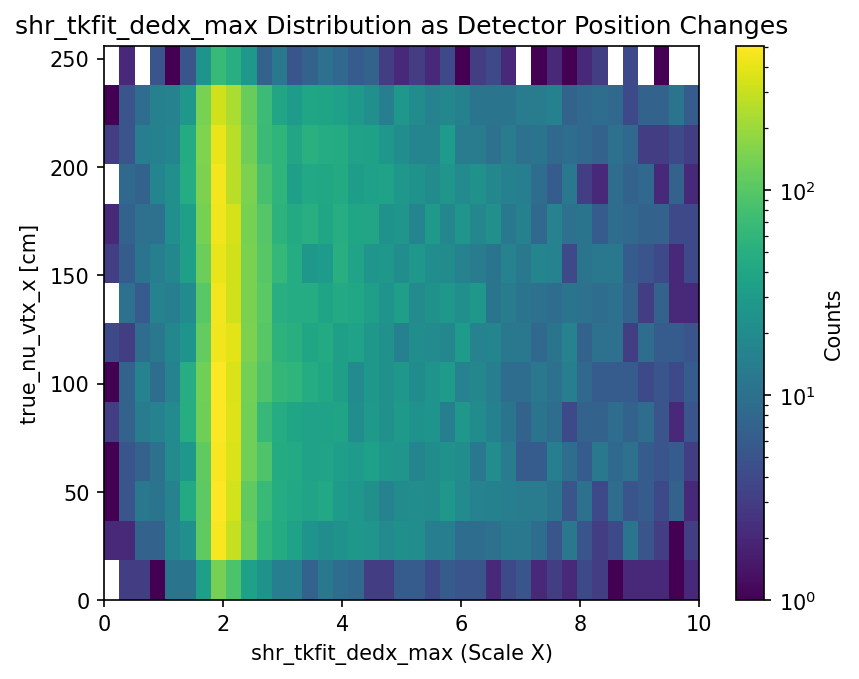

In [306]:
# 2d histogram for direction and var

hist_bins = np.linspace(0,10,40)

selection_variation_index = 1

df = df_list[selection_variation_index].loc[direction_index[selection_variation_index]]
# df = df_list[selection_variation_index].loc[rel_error_index]

values = df[var]
positions = df[direction]

fig, ax = plt.subplots(dpi=150)

_, _, _, im = ax.hist2d(values, positions, bins=[hist_bins, split_bins], norm=mpl.colors.LogNorm())

cbar = fig.colorbar(im)

cbar.set_label(f'Counts')

ax.set_ylabel(f'{direction} [cm]')
ax.set_xlabel(f'{var} ({plot_labels[selection_variation_index]})')

ax.set_title(f'{var} Distribution as Detector Position Changes')

Text(0.5, 1.0, 'shr_tkfit_dedx_max Distribution as Detector Position Changes')

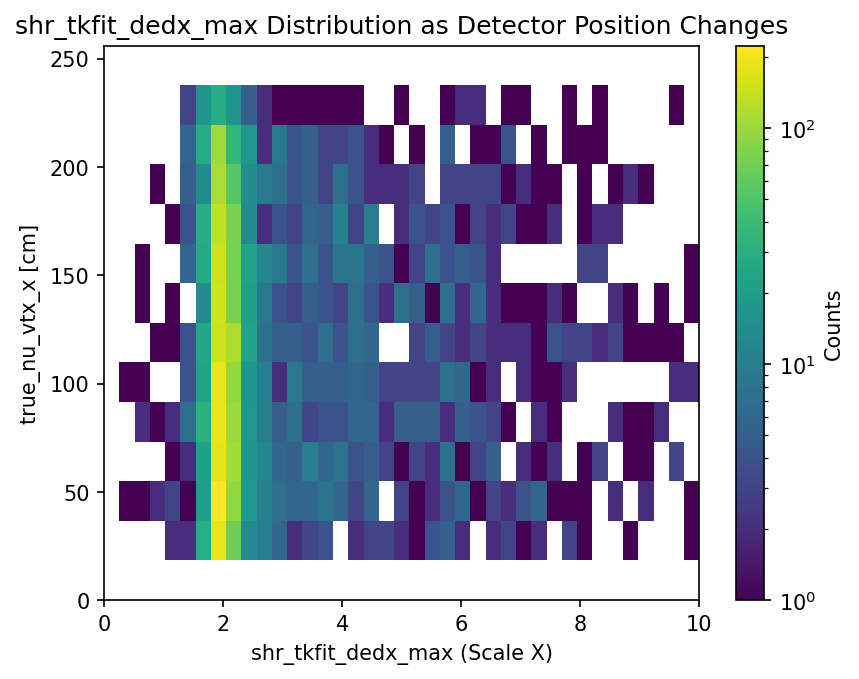

In [307]:
# 2d histogram for direction and var (just in box)

hist_bins = np.linspace(0,10,40)

selection_variation_index = 1

# df = df_list[selection_variation_index].loc[direction_index[selection_variation_index]]
df = df_list[selection_variation_index].loc[rel_error_index]

values = df[var]
positions = df[direction]

fig, ax = plt.subplots(dpi=150)

_, _, _, im = ax.hist2d(values, positions, bins=[hist_bins, split_bins], norm=mpl.colors.LogNorm())

cbar = fig.colorbar(im)

cbar.set_label(f'Counts')

ax.set_ylabel(f'{direction} [cm]')
ax.set_xlabel(f'{var} ({plot_labels[selection_variation_index]})')

ax.set_title(f'{var} Distribution as Detector Position Changes')